See the `intro_to_inla.ipynb` notebook for an introduction to the methods and model used here.

In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
import matplotlib.pyplot as plt

import scipy.stats
import numpy as np
from scipy.special import logit, expit

import berrylib.dirty_bayes as dirty_bayes
import berrylib.quadrature as quadrature
import berrylib.mcmc as mcmc
import berrylib.fast_inla as fast_inla
fi = fast_inla.FastINLA(sigma2_n=90)

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
p0 = np.full(4, 0.1)
p1 = np.full(4, 0.3)
pmid = (p0 + p1) / 2
pmid_theta = logit(pmid) - fi.logit_p1
pmid_fail = 0.05
pmid_success = 0.90
pfinal_thresh = np.full(4, 0.85)
thresh_interims = np.empty((6, 4))
thresh_interims[:-1] = pmid_theta
thresh_interims[-1] = fi.thresh_theta[0]

def figure1_plot(b, title, data, stats):
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle(title)
    outergs = fig.add_gridspec(2, 3, hspace=0.3)
    for i in range(data.shape[0]):
        innergs = outergs[i].subgridspec(
            2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
        )
        figure1_subplot(innergs[0], innergs[1], i, b, data, stats)

    plt.show()


def figure1_subplot(gridspec0, gridspec1, i, b, data, stats, title=None):
    plt.subplot(gridspec0)

    # expit(mu_map) is the posterior estimate of the mean probability.
    p_post = expit(stats["theta_map"] + b.logit_p1)

    cilow = expit(stats["cilow"] + b.logit_p1)
    cihi = expit(stats["cihi"] + b.logit_p1)

    y = data[:, :, 0]
    n = data[:, :, 1]

    # The simple ratio of success to samples. Binomial "p".
    raw_ratio = y / n

    plt.plot(np.arange(4), raw_ratio[i], "kx")
    plt.plot(np.arange(4), p_post[i], "ko", mfc="none")
    plt.plot(np.arange(4), stats["exceedance"][i], "k ", marker=(8, 2, 0))

    plt.vlines(np.arange(4), cilow[i], cihi[i], color="k", linewidth=1.0)

    if i < 5:
        if title is None:
            title = f"Interim Analysis {i+1}"
        plt.hlines([pmid_fail, pmid_success], -1, 4, colors=["k"], linestyles=["--"])
        plt.text(-0.1, 0.91, "Early Success", fontsize=7)
        plt.text(2.4, 0.06, "Early Futility", fontsize=7)
    else:
        if title is None:
            title = "Final Analysis"
        plt.hlines([pfinal_thresh[0]], -1, 4, colors=["k"], linestyles=["--"])
        plt.text(-0.1, 0.86, "Final Success", fontsize=7)
    plt.title(title)

    plt.xlim([-0.3, 3.3])
    plt.ylim([0.0, 1.05])
    plt.yticks(np.linspace(0.0, 1.0, 6))
    plt.xlabel("Group")
    plt.ylabel("Probability")

    plt.subplot(gridspec1)
    plt.bar(
        [0, 1, 2, 3],
        n[i],
        tick_label=[str(i) for i in range(4)],
        color=(0.6, 0.6, 0.6, 1.0),
        edgecolor="k",
        zorder=0,
    )
    plt.bar(
        [0, 1, 2, 3],
        y[i],
        color=(0.6, 0.6, 0.6, 1.0),
        hatch="////",
        edgecolor="w",
        lw=1.0,
        zorder=1,
    )
    #         # draw hatch
    # ax1.bar(range(1, 5), range(1, 5), color='none', edgecolor='red',
    # hatch="/", lw=1., zorder = 0)
    # # draw edge
    plt.bar([0, 1, 2, 3], y[i], color="none", edgecolor="k", zorder=2)
    ticks = np.arange(0, 36, 5)
    plt.yticks(ticks, [str(i) if i % 10 == 0 else "" for i in ticks])
    plt.xticks(np.arange(4), ["1", "2", "3", "4"])
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xlabel("Group")
    plt.ylabel("N")

def inla_figure1_data(fi, y, n):
    sigma2_post, exceedances, theta_max, theta_sigma, _ = fi.numpy_inference(y, n, thresh_theta=thresh_interims)
    return dict(
        theta_map = np.sum(theta_max * sigma2_post[:,:, None] * fi.sigma2_rule.wts[None, :, None], axis=1),
        cilow = np.sum((theta_max - 2 * theta_sigma) * sigma2_post[:,:, None] * fi.sigma2_rule.wts[None, :, None], axis=1),
        cihi = np.sum((theta_max + 2 * theta_sigma) * sigma2_post[:,:, None] * fi.sigma2_rule.wts[None, :, None], axis=1),
        exceedance=exceedances
    )

In [4]:

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10, 15, 20, 25, 30, 35]])
y_i = np.array(
    [
        [1, 6, 3, 3],
        [3, 8, 5, 4],
        [6, 9, 7, 5],
        [7, 10, 8, 7],
        [8, 10, 9, 8],
        [11, 11, 10, 9],
    ]
)
data = np.stack((y_i, n_i), axis=2)

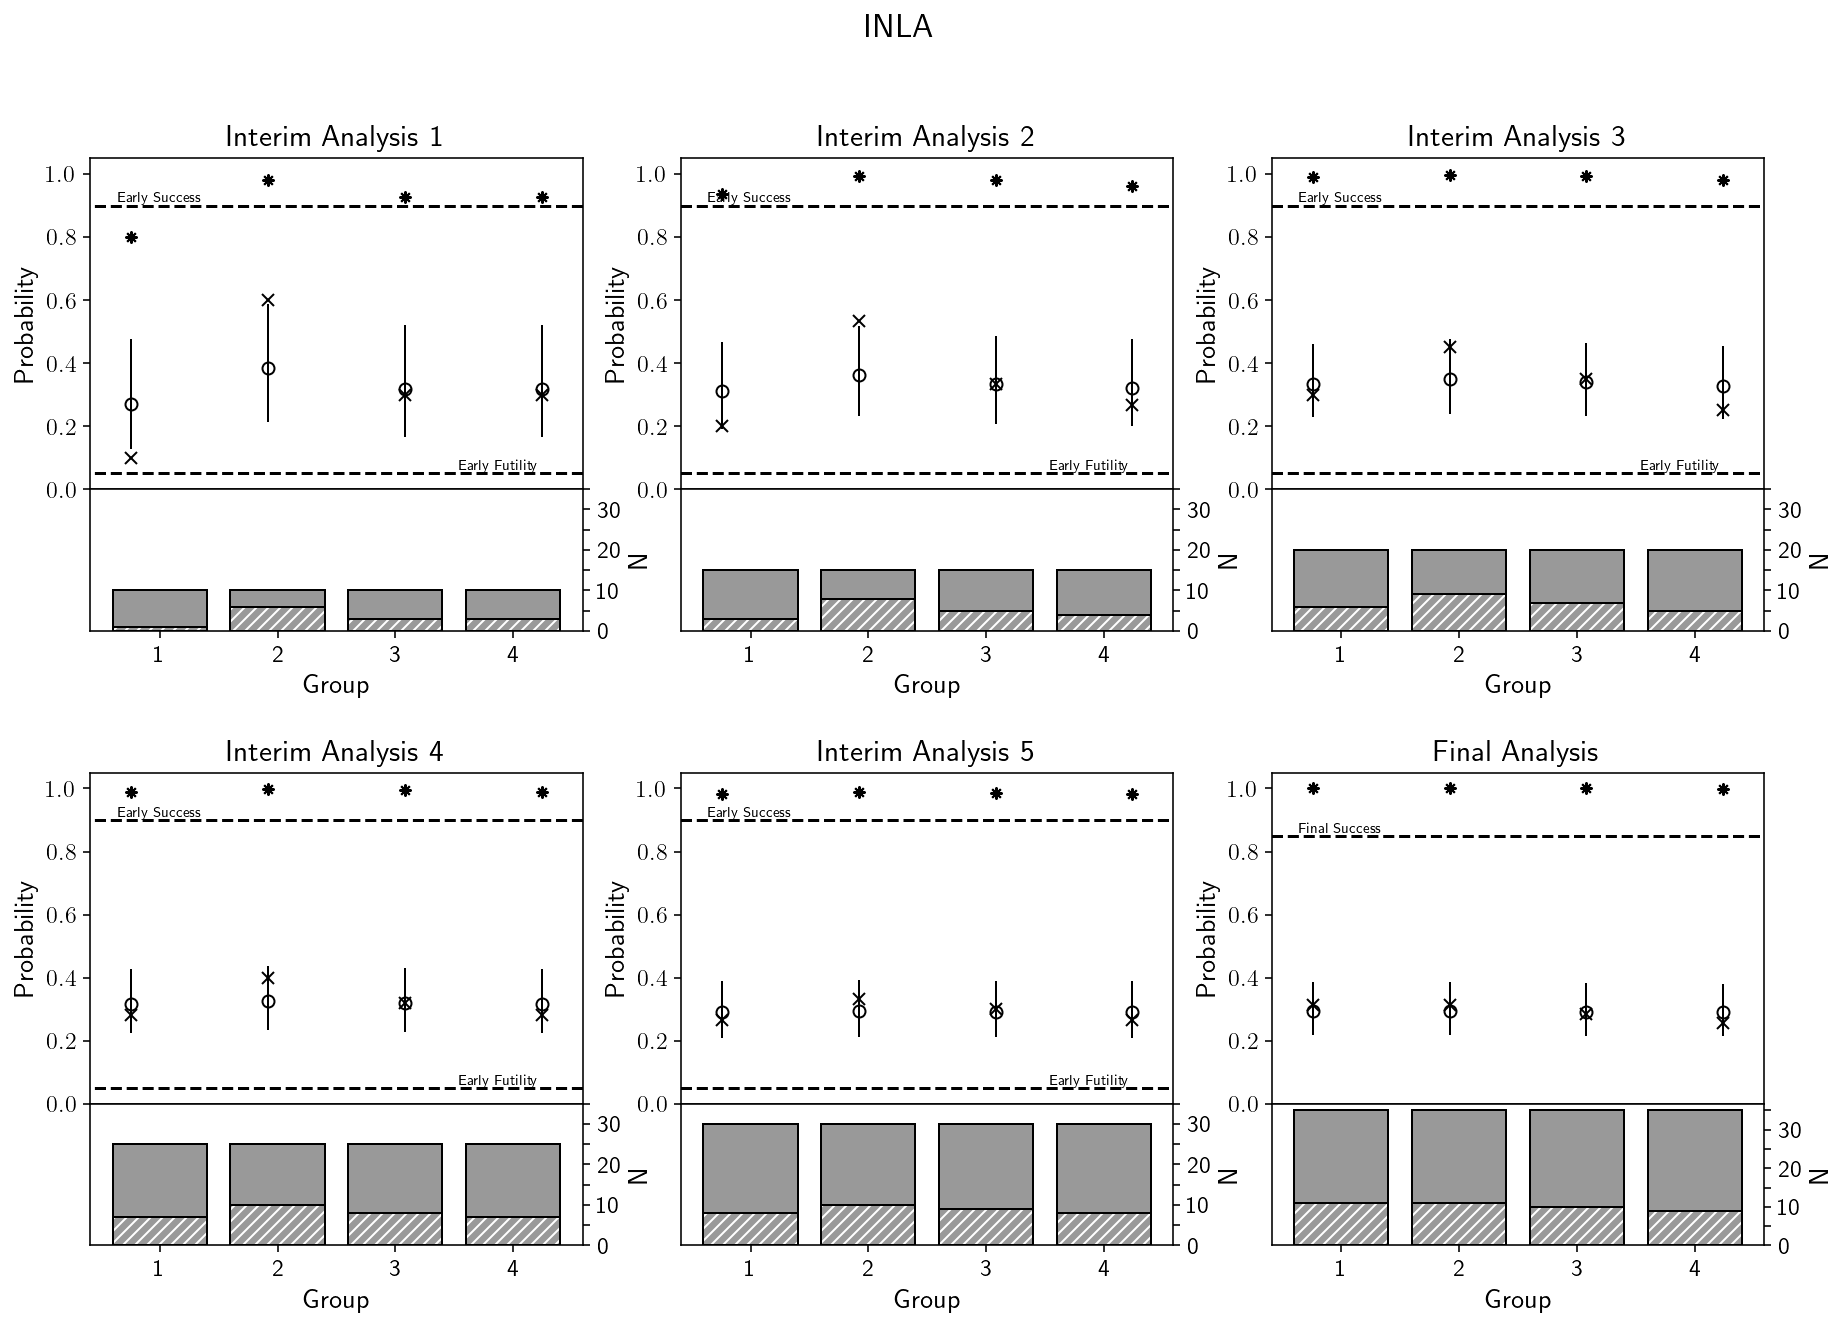

In [5]:
inla_stats = inla_figure1_data(fi, y_i, n_i)
figure1_plot(fi, "INLA", data, inla_stats)

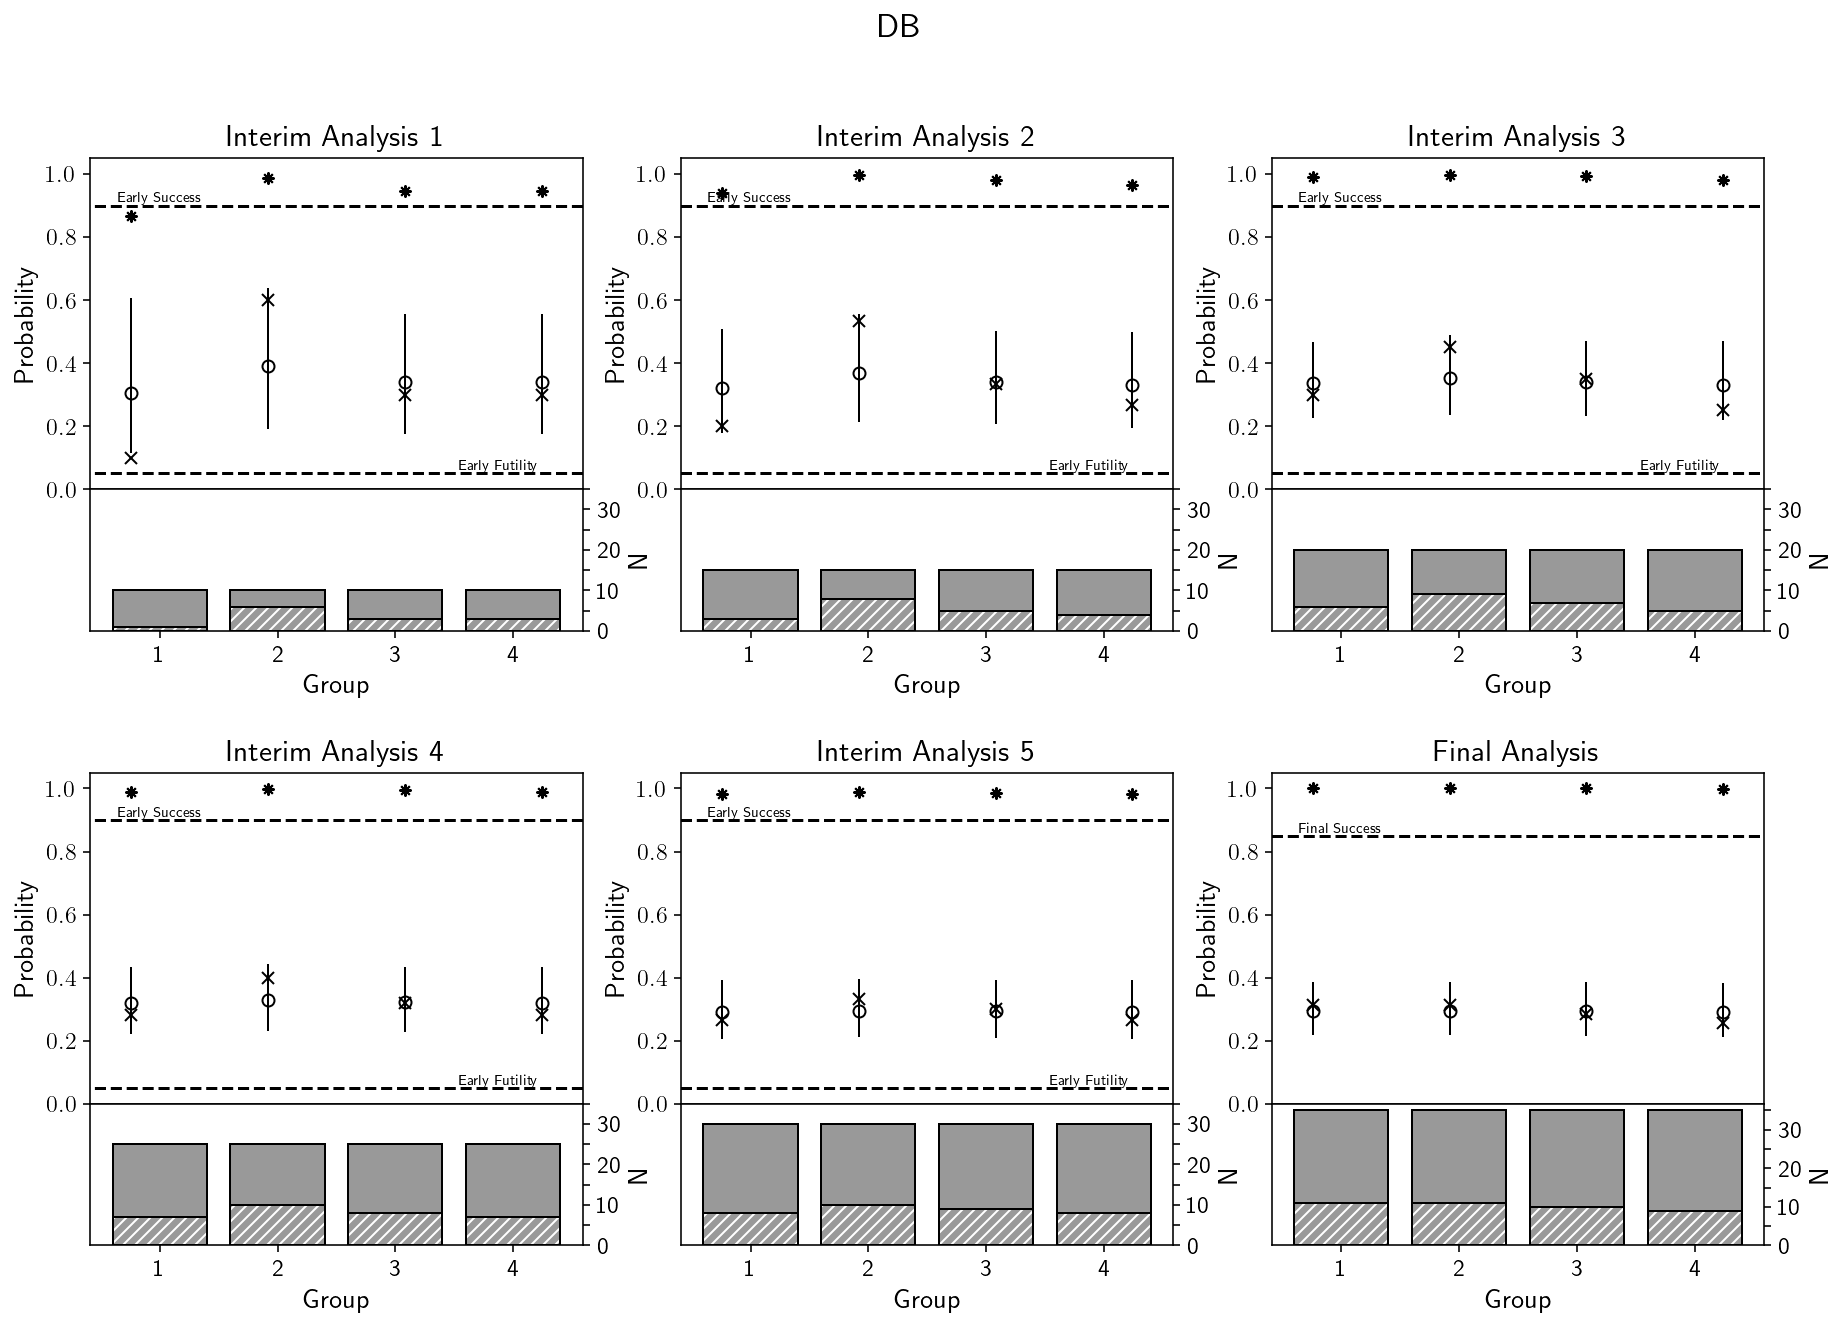

In [6]:
db_stats = dirty_bayes.calc_dirty_bayes(
    y_i, n_i, fi.mu_0, fi.logit_p1, thresh_interims, fi.sigma2_rule
)
figure1_plot(fi, "DB", data, db_stats)

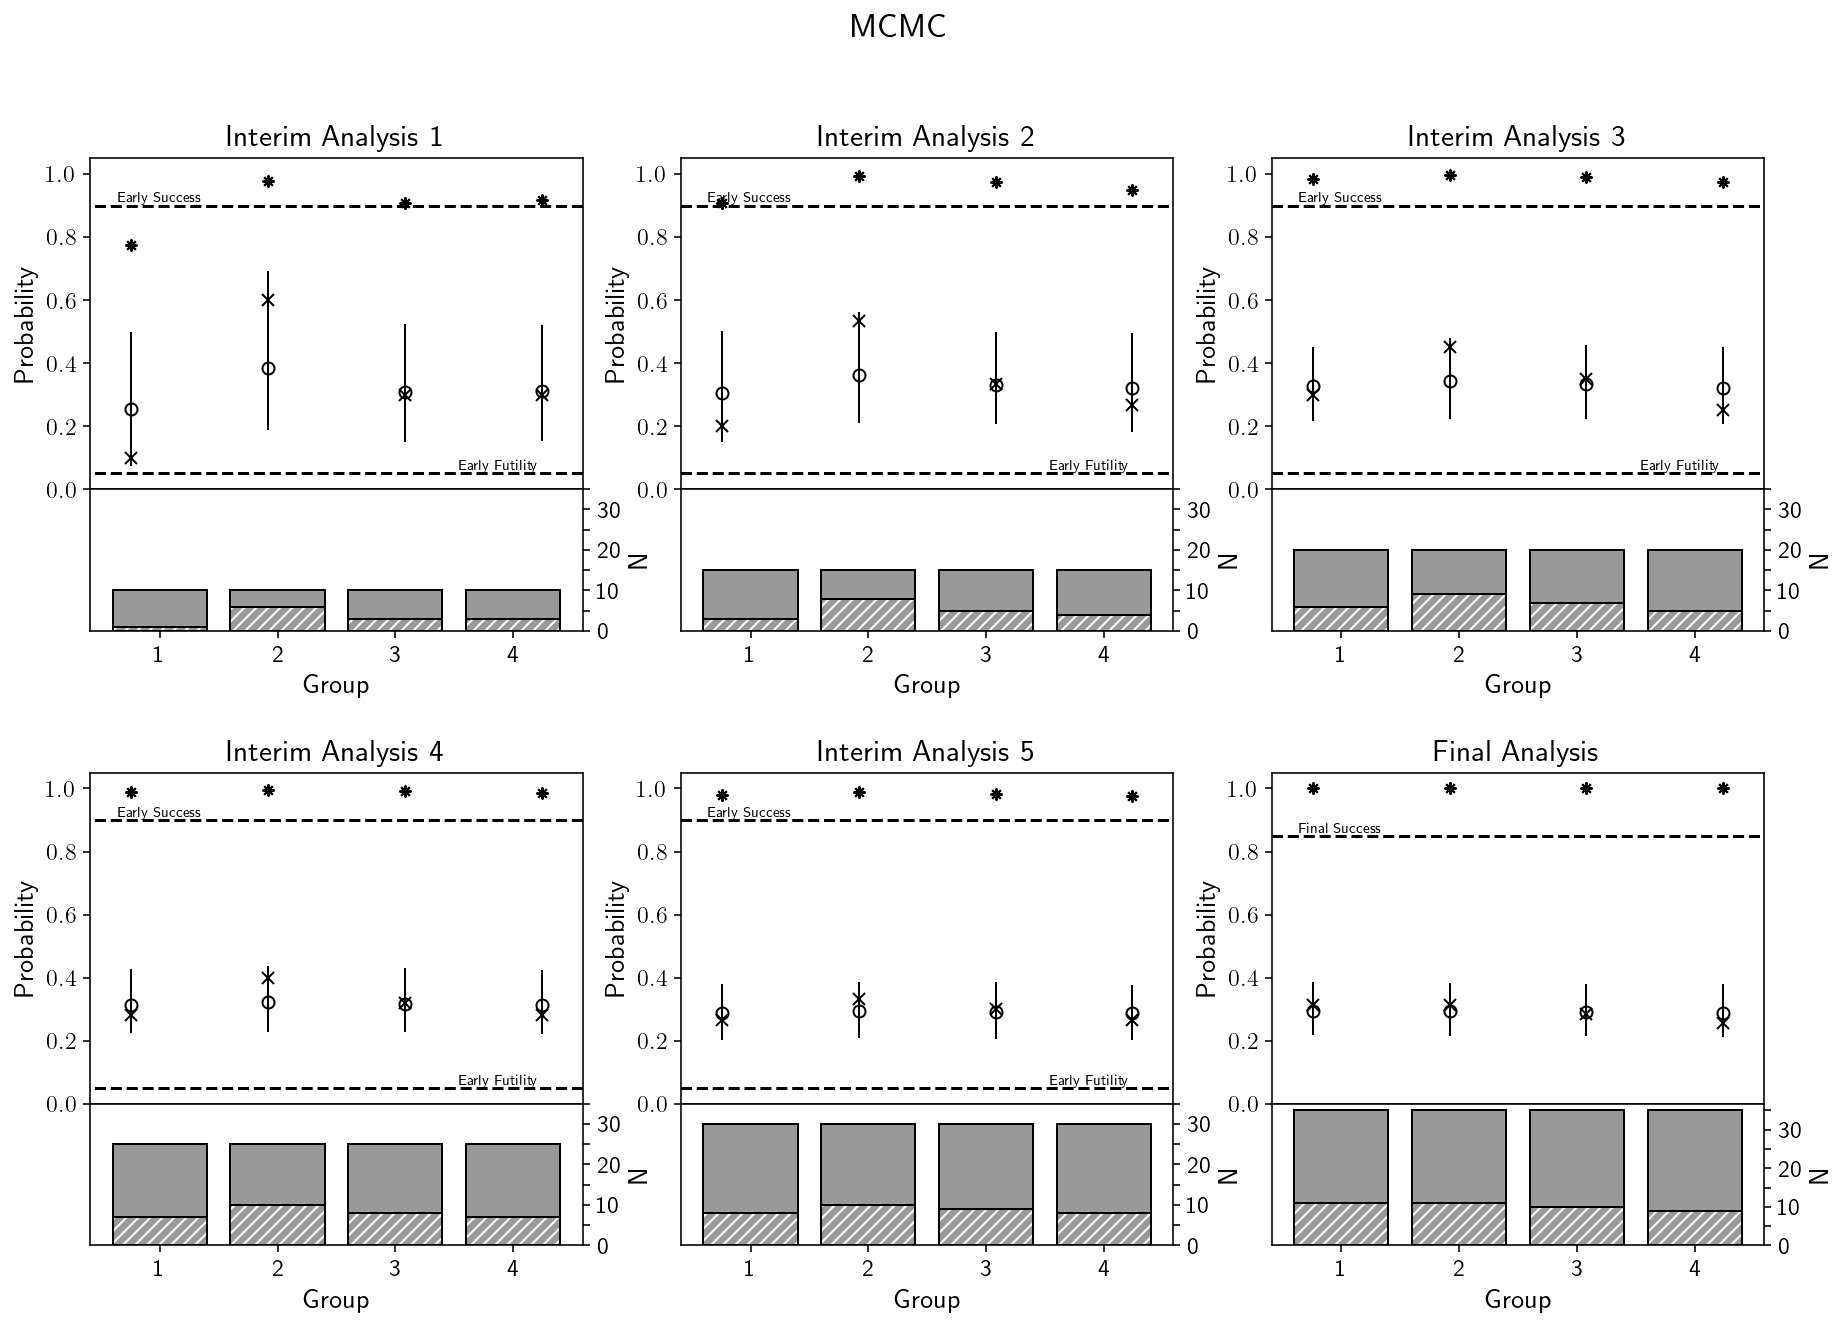

In [55]:
mcmc_stats = mcmc.mcmc_berry(data, fi.logit_p1, thresh_interims, n_samples=50000)
figure1_plot(fi, "MCMC", data, mcmc_stats)

In [7]:
%%time
fi_q = fast_inla.FastINLA()
quad_stats = quadrature.quadrature_posterior_theta(fi_q, y_i, n_i, thresh_interims)

CPU times: user 19.7 s, sys: 603 ms, total: 20.3 s
Wall time: 7 s


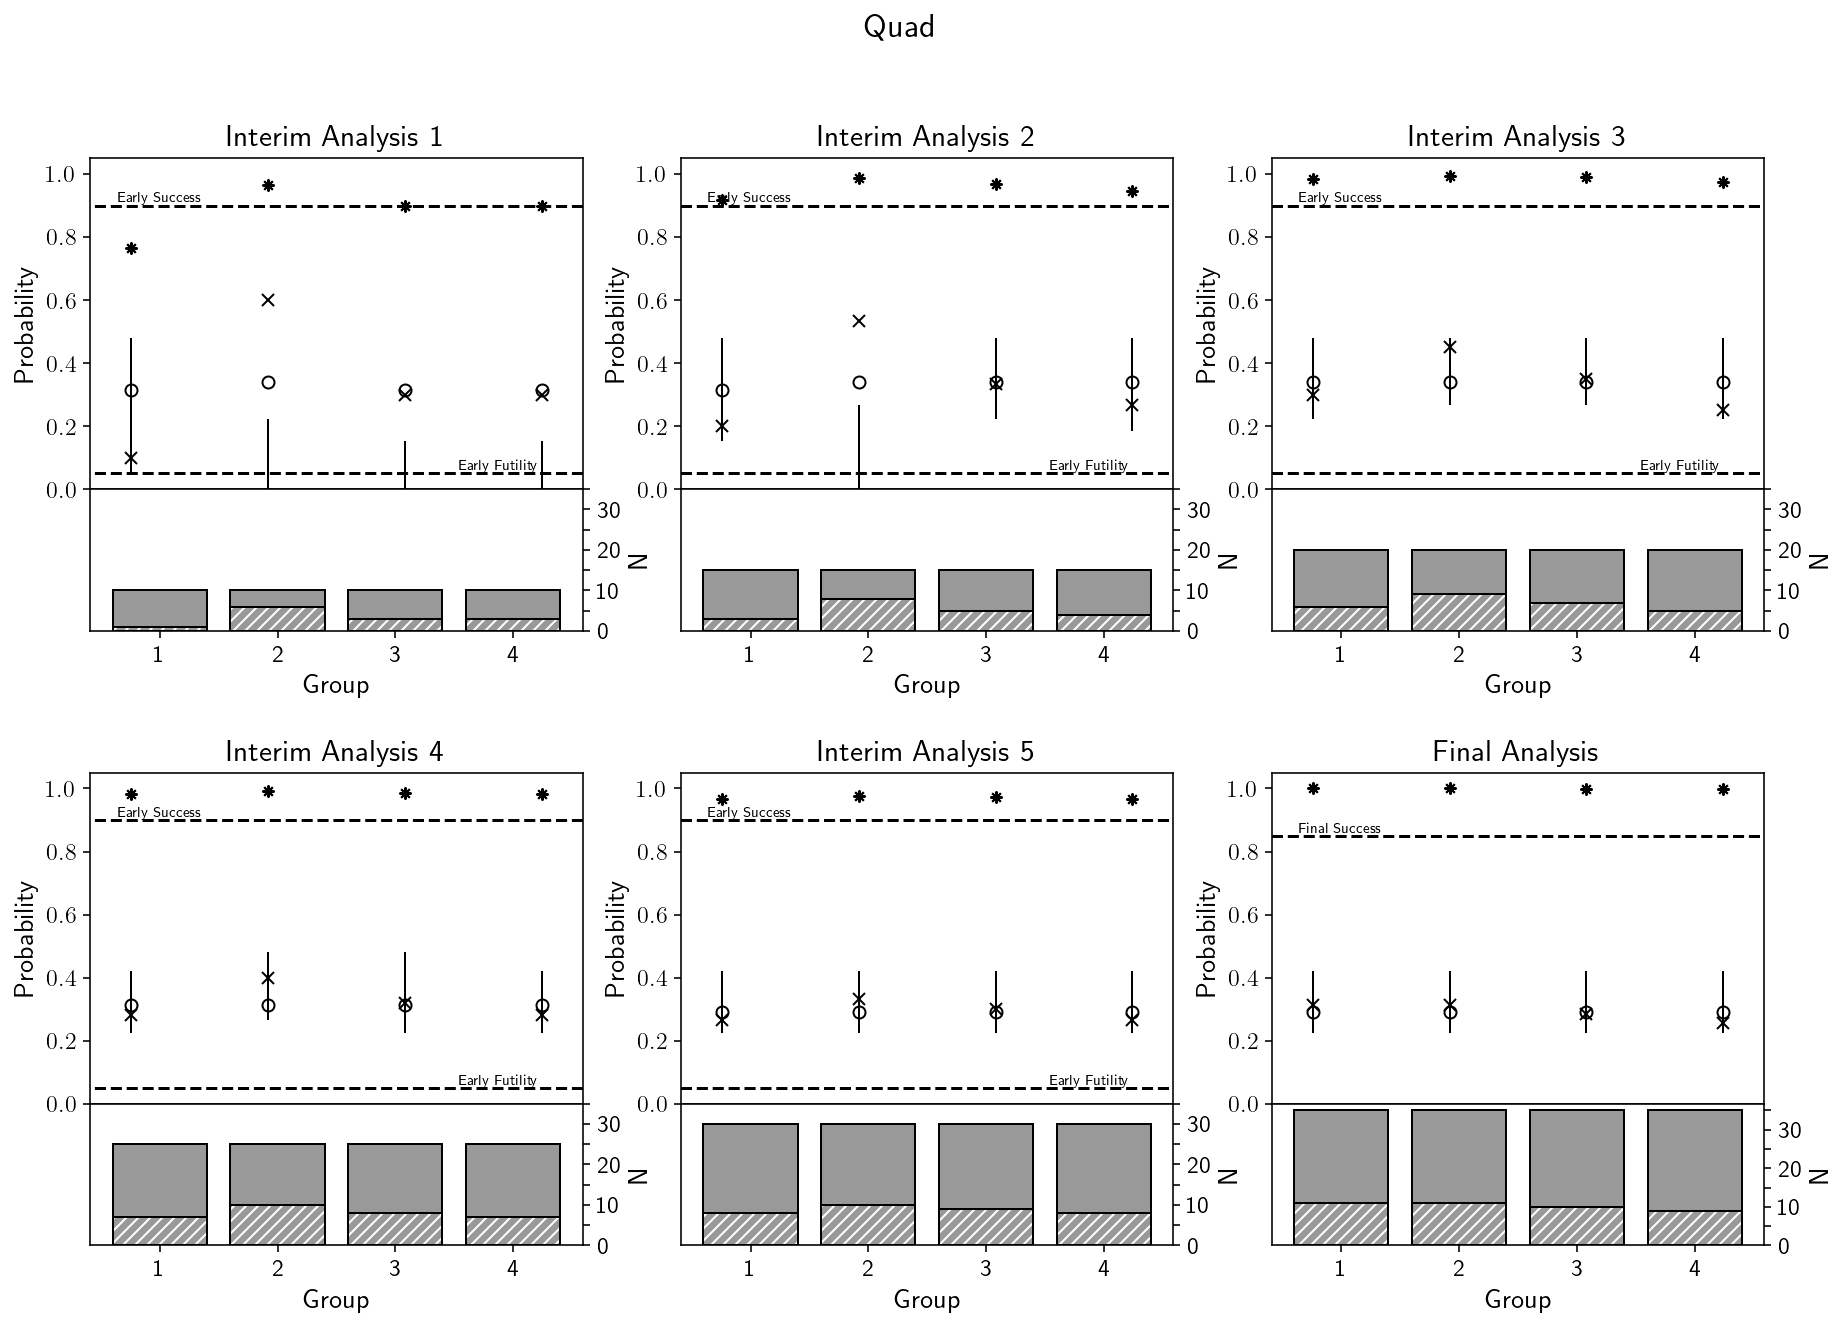

In [8]:
figure1_plot(fi_q, "Quad", data, quad_stats)

# Figure 2

In [60]:
# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array(
    [
        [10, 10, 10, 10],
        [15, 15, 15, 15],
        [20, 20, 20, 20],
        [20, 20, 25, 25],
        [20, 20, 30, 30],
        [20, 20, 35, 35],
    ]
)
y_i = np.array(
    [
        [0, 1, 3, 3],
        [0, 1, 4, 5],
        [0, 1, 6, 6],
        [0, 1, 6, 7],
        [0, 1, 7, 8],
        [0, 1, 9, 10],
    ],
    dtype=np.float64,
)
data = np.stack((y_i, n_i), axis=2)

y_i_no0 = y_i.copy()
y_i_no0[y_i_no0 == 0] = 0.5
data_no0 = np.stack((y_i_no0, n_i), axis=2)

inla_stats = inla_figure1_data(fi, y_i, n_i)
db_stats = dirty_bayes.calc_dirty_bayes(
    y_i_no0, n_i, fi.mu_0, fi.logit_p1, thresh_interims, fi.sigma2_rule
)
mcmc_stats = mcmc.mcmc_berry(data, fi.logit_p1, thresh_interims)
quad_stats = quadrature.quadrature_posterior_theta(fi_q, y_i, n_i, thresh_interims)

/Users/tbent/Dropbox/active/fda/kevlar/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


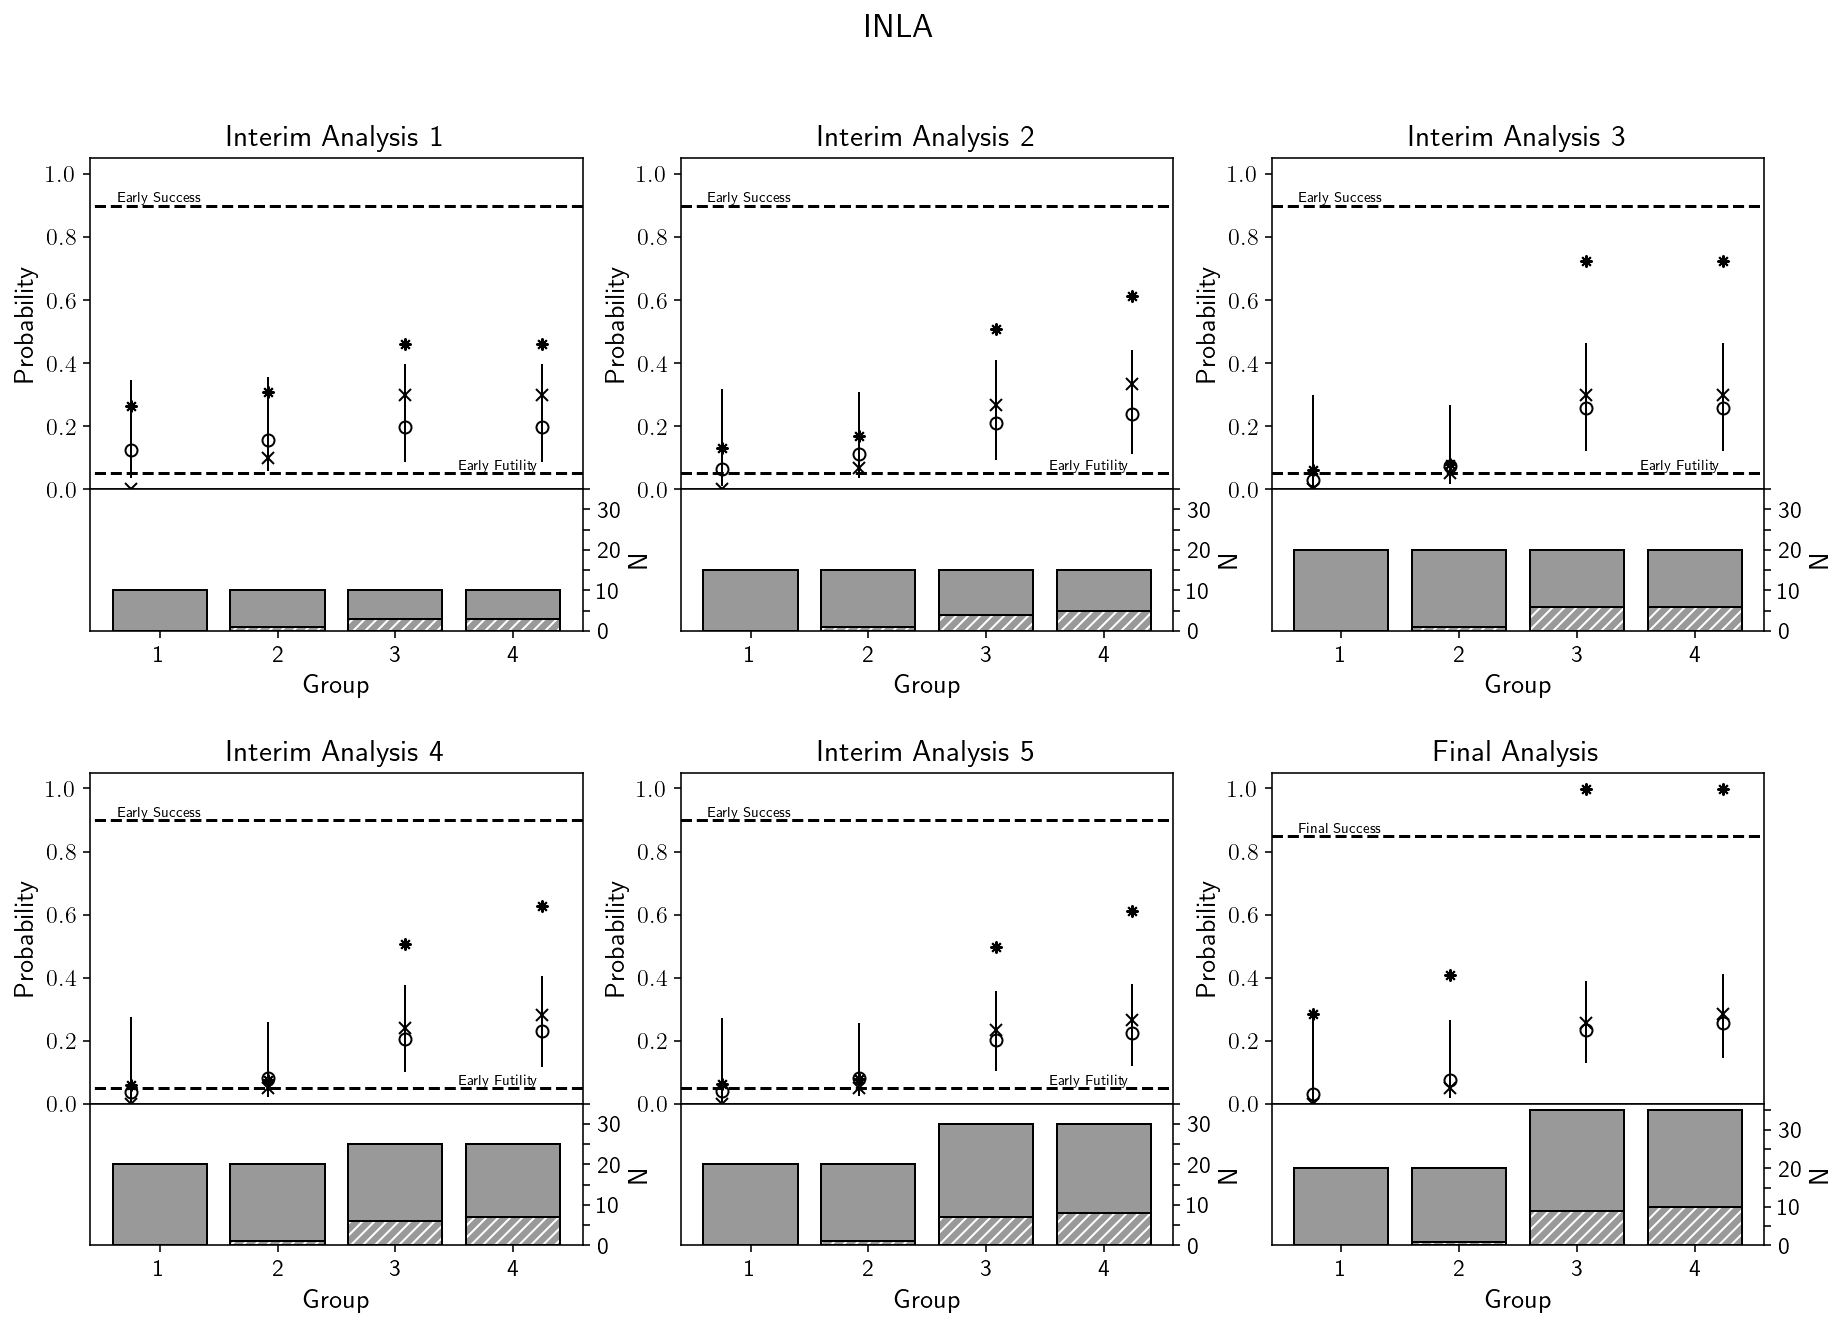

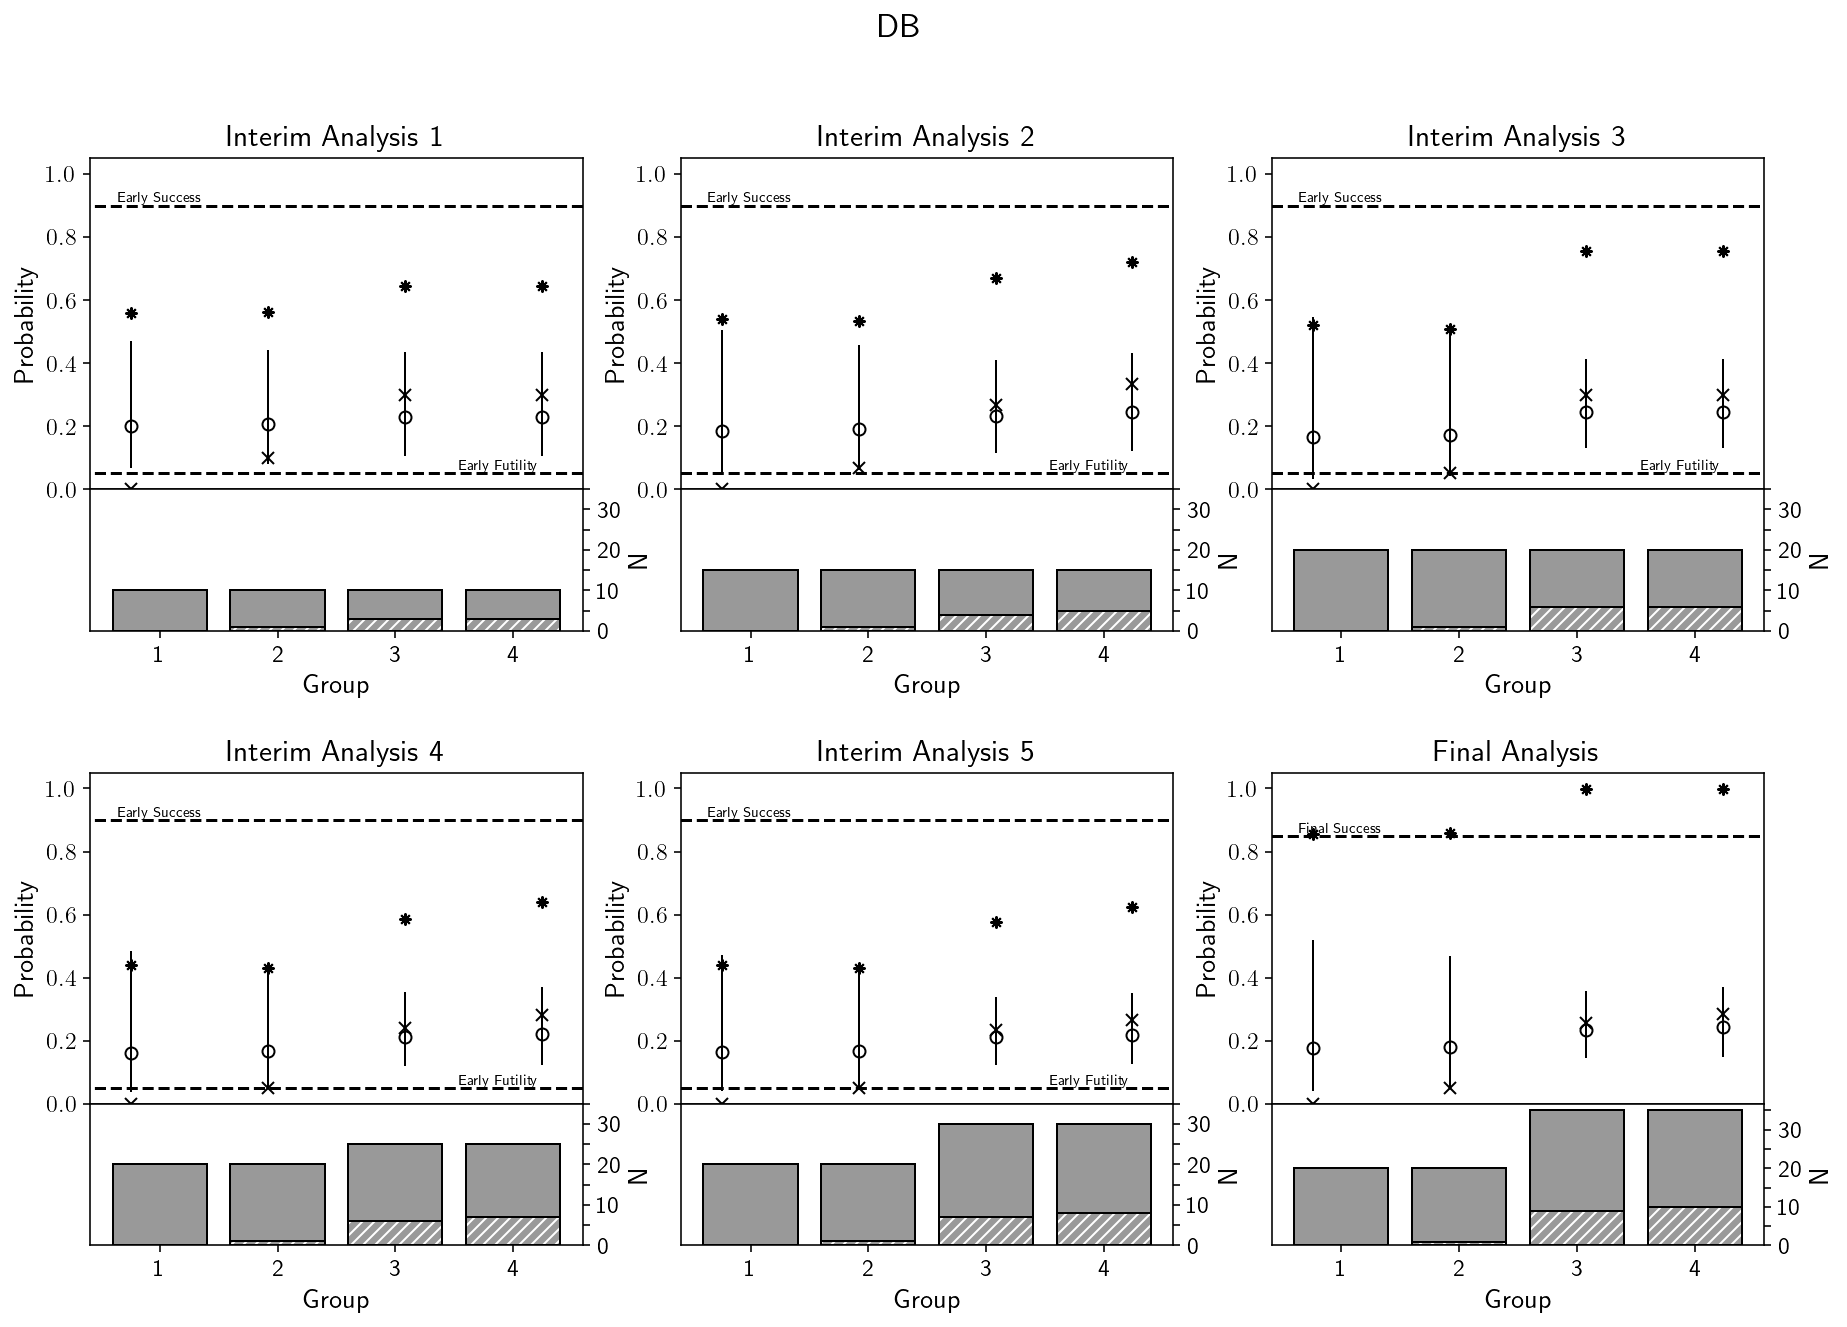

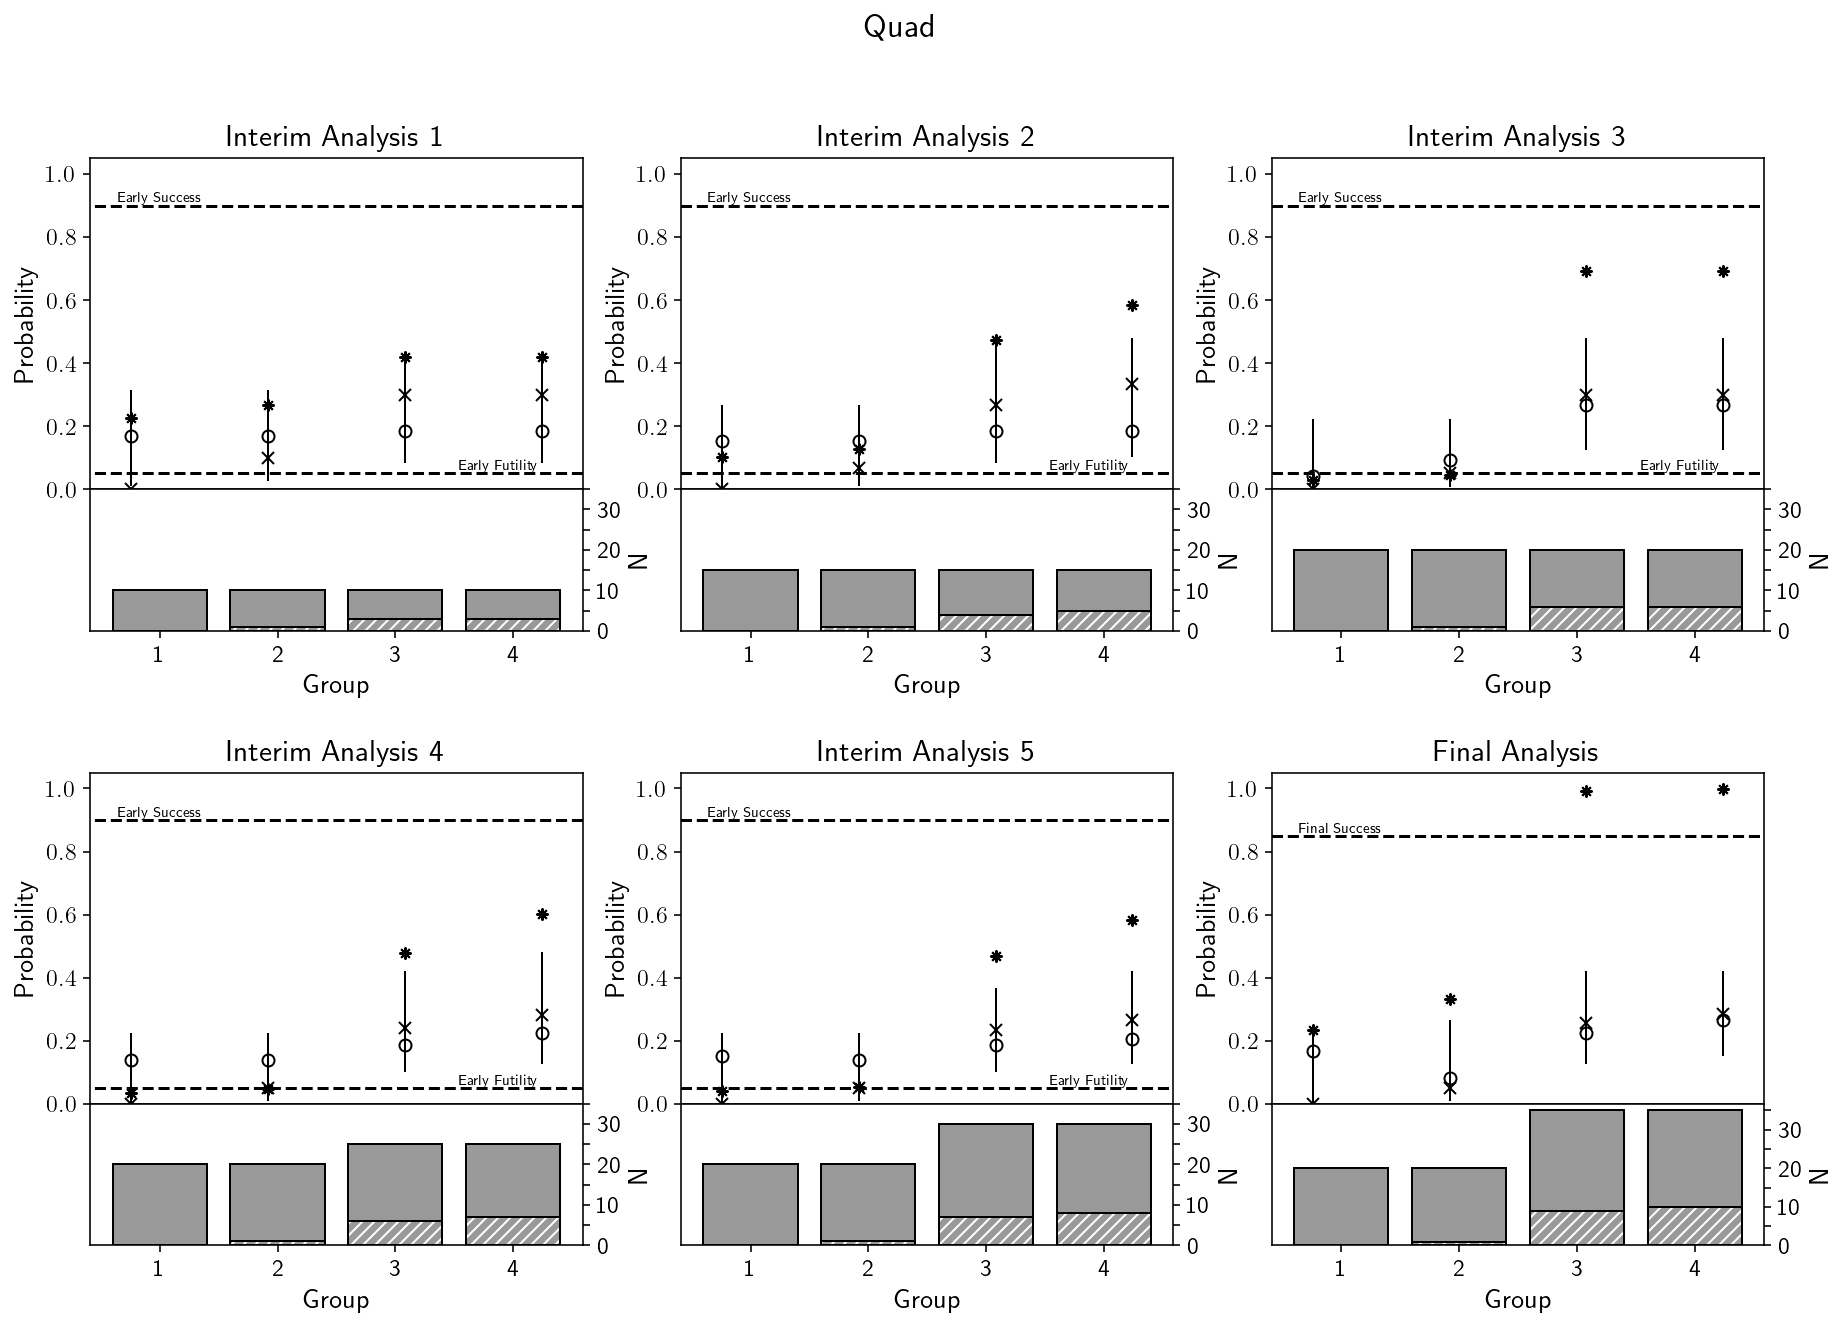

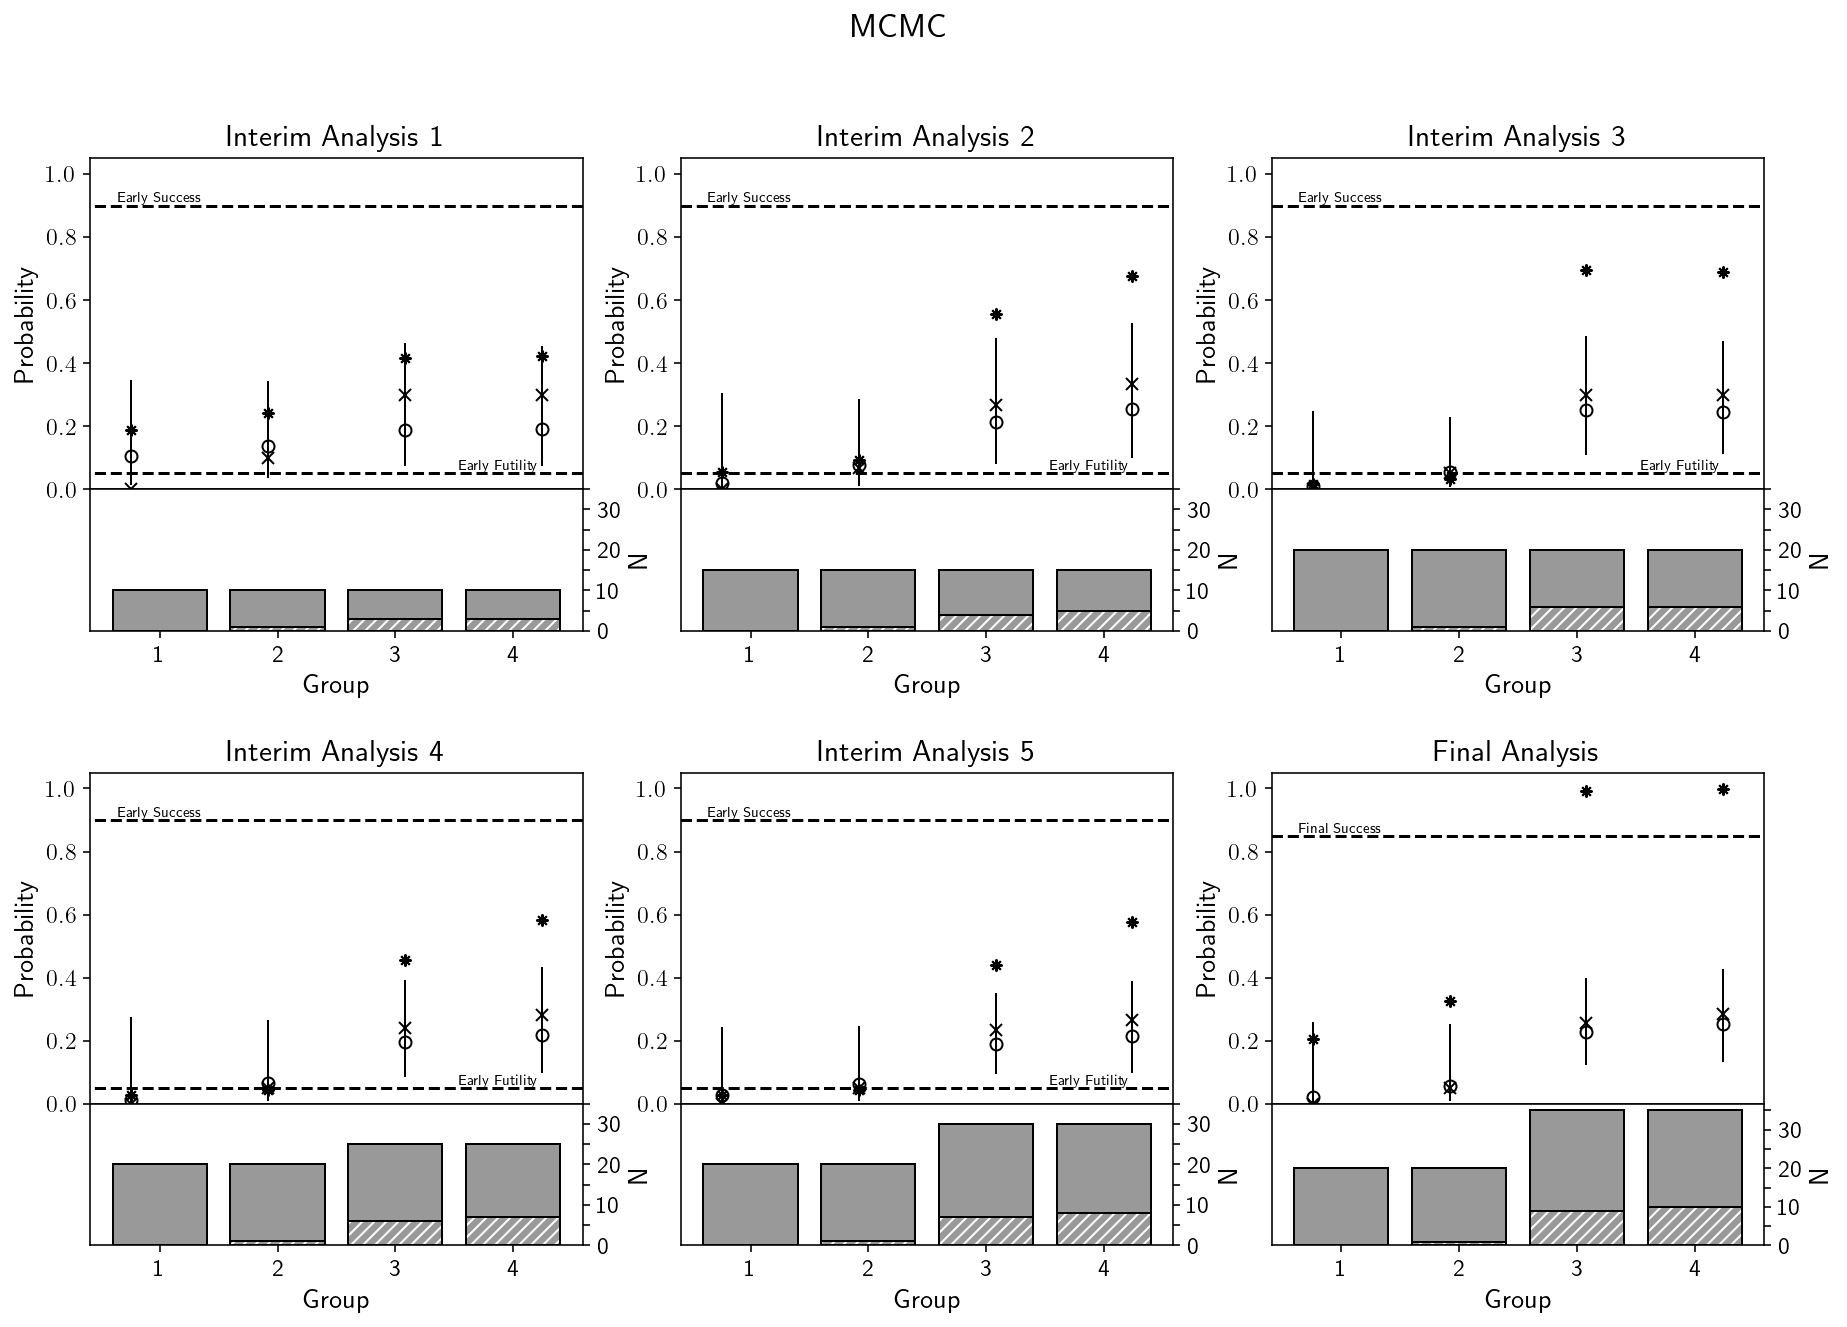

In [61]:
figure1_plot(fi, "INLA", data, inla_stats)
figure1_plot(fi, "DB", data, db_stats)
figure1_plot(fi_q, "Quad", data, quad_stats)
figure1_plot(fi, "MCMC", data, mcmc_stats)

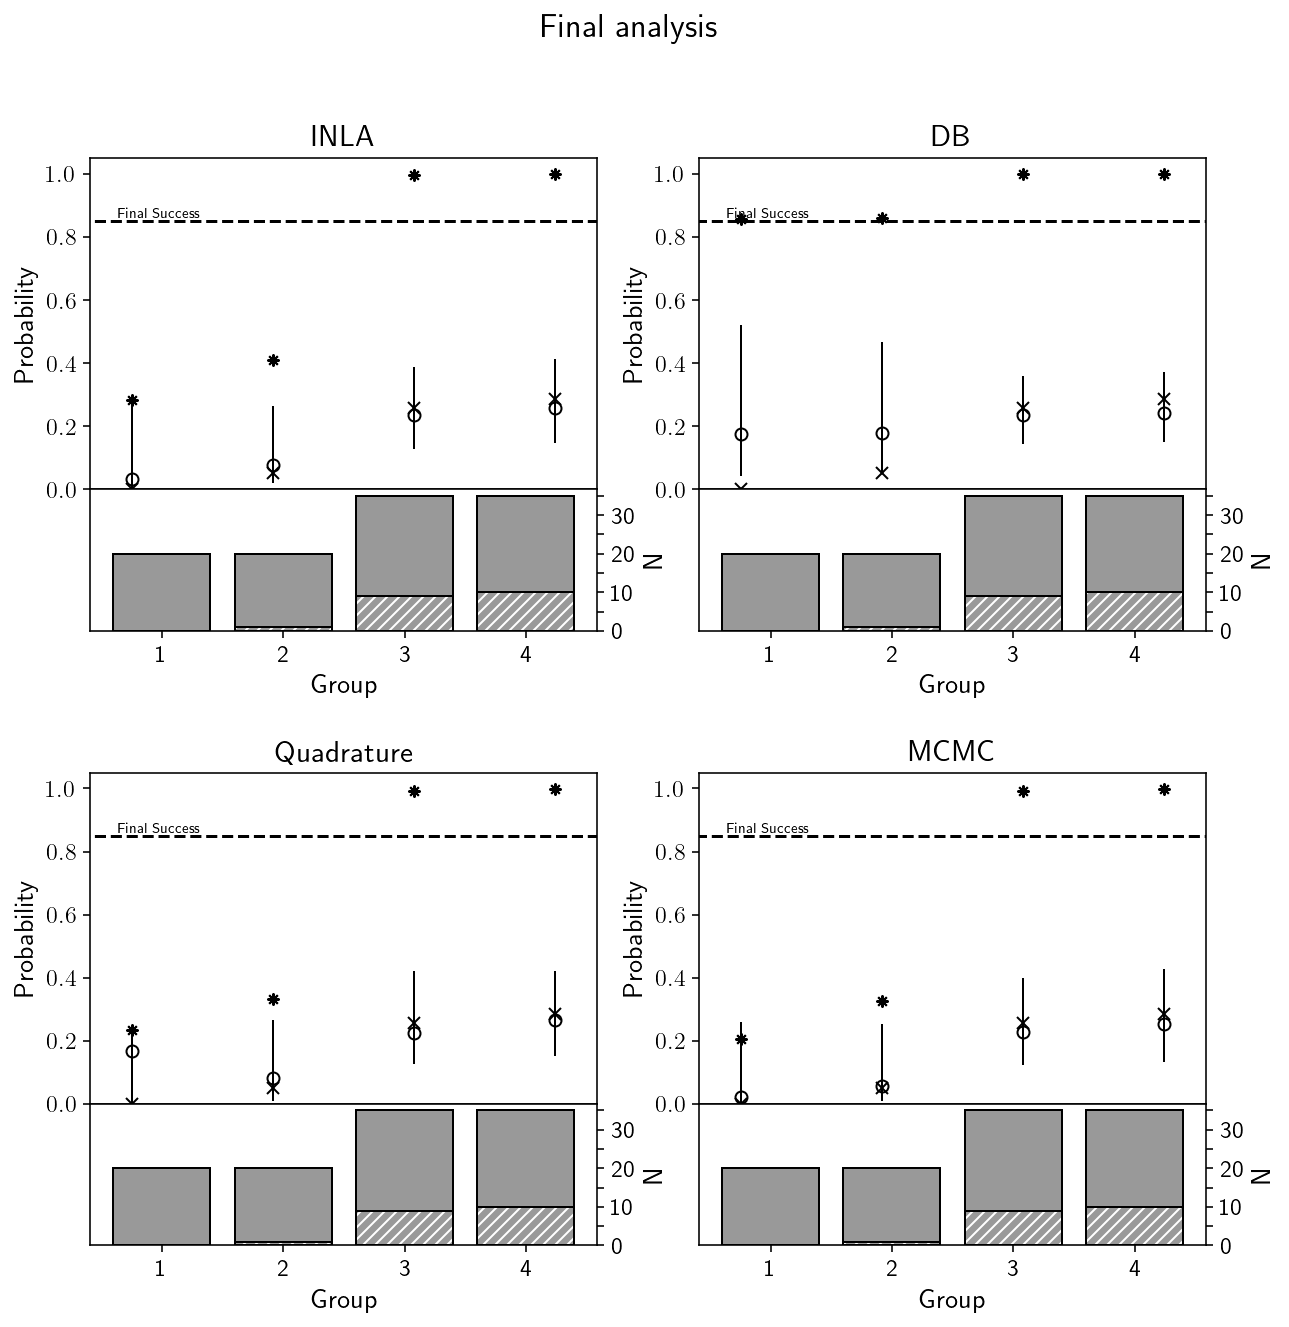

In [63]:
fig = plt.figure(figsize=(10, 10))
plt.suptitle("Final analysis")
outergs = fig.add_gridspec(2, 2, hspace=0.3)
innergs = outergs[0].subgridspec(2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3])
figure1_subplot(innergs[0], innergs[1], 5, fi, data, inla_stats, title="INLA")
innergs = outergs[1].subgridspec(2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3])
figure1_subplot(innergs[0], innergs[1], 5, fi, data, db_stats, title="DB")
innergs = outergs[2].subgridspec(2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3])
figure1_subplot(
    innergs[0], innergs[1], 5, fi, data, quad_stats, title="Quadrature"
)
innergs = outergs[3].subgridspec(2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3])
figure1_subplot(innergs[0], innergs[1], 5, fi, data, mcmc_stats, title="MCMC")

# Old marginal figures (for new, see berry_marginal_playground), debugging

## Looking at $p(\theta_i|y_k)$

In [ ]:
y_i_no0 = y_i.copy()
y_i_no0[y_i_no0 == 0] = 0.00001
data_no0 = np.stack((y_i_no0, n_i), axis=2)
db_stats = dirty_bayes.calc_dirty_bayes(
    y_i_no0, n_i, b.mu_0, b.logit_p1, b.suc_thresh, b.sigma2_rule
)

In [ ]:
post_hyper, report = inla.calc_posterior_hyper(b, data)
inla_stats = inla.calc_posterior_x(post_hyper, report, b.suc_thresh)

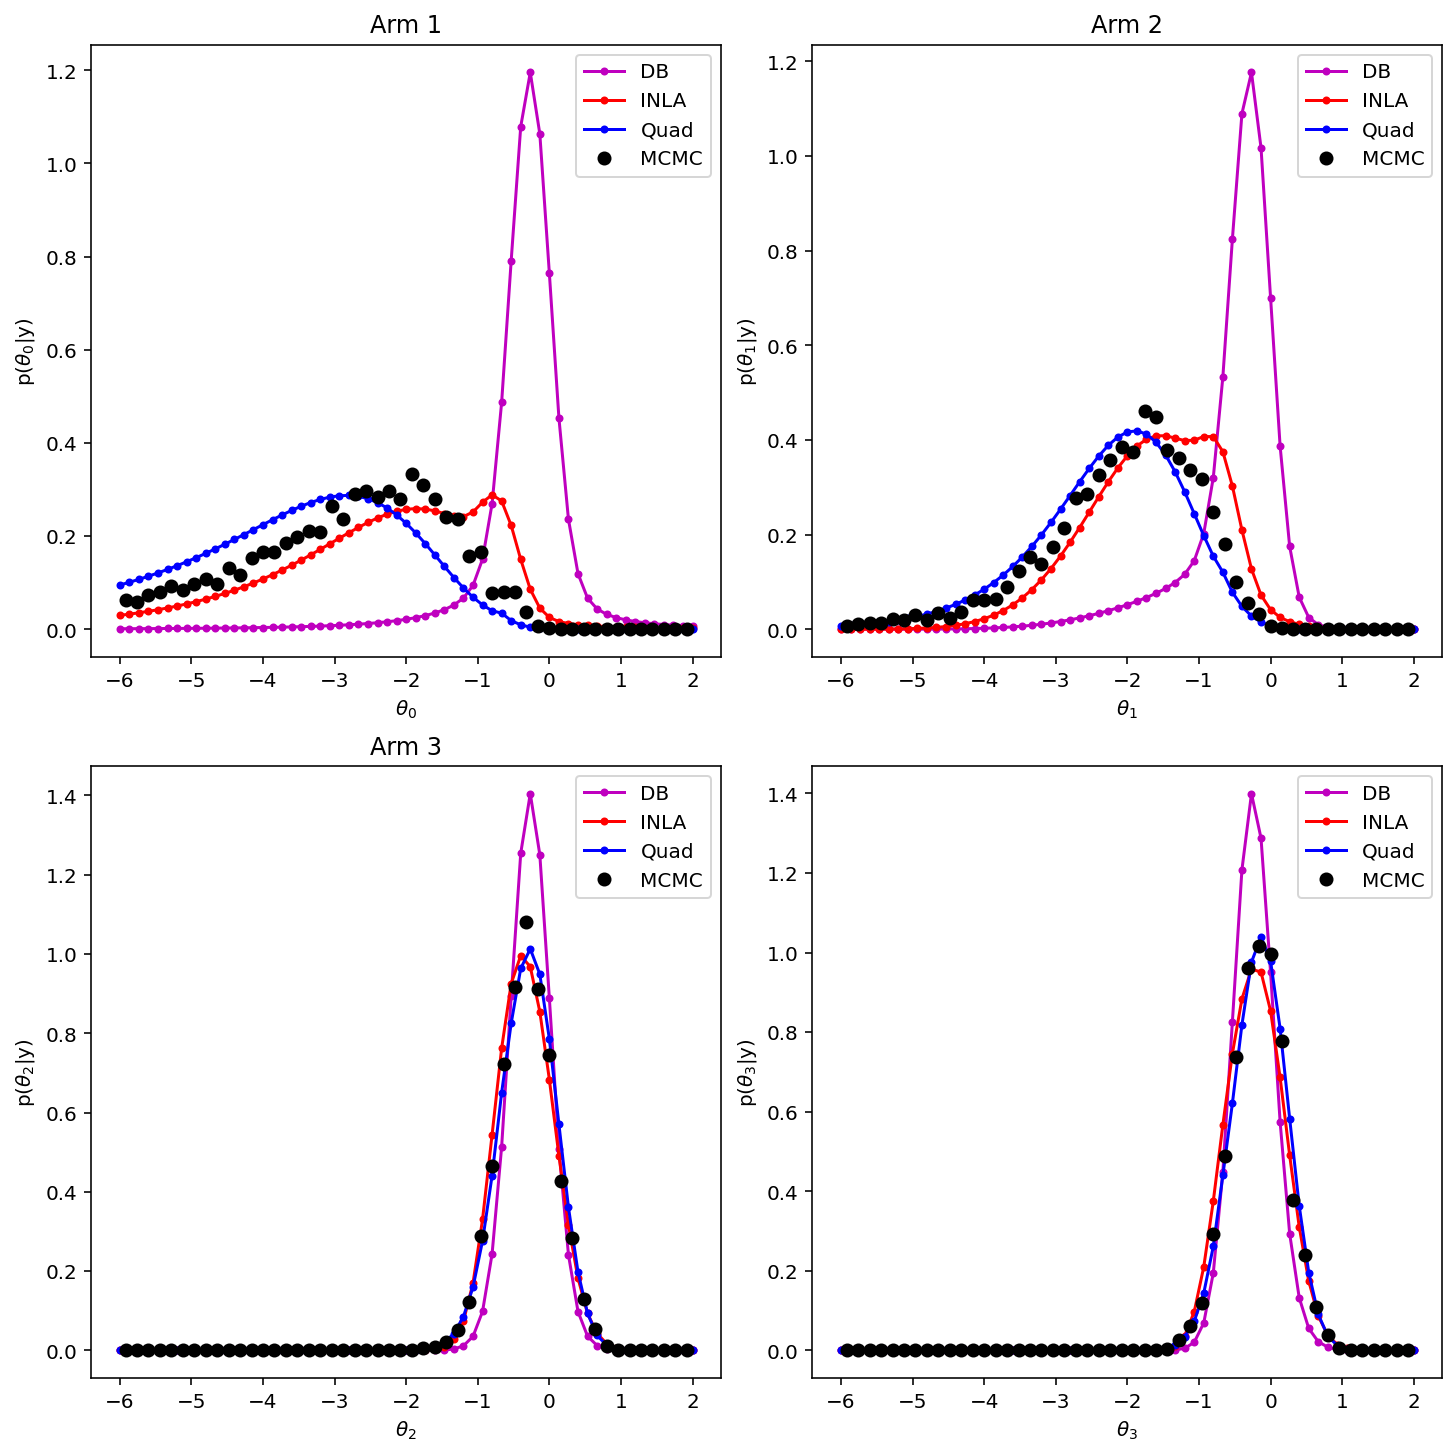

In [ ]:
look_idx = 5
plt.figure(figsize=(10, 10), constrained_layout=True)
for arm_idx in range(4):
    # Quadrature
    ti_rule = util.simpson_rule(61, -6.0, 2.0)
    integrate_dims = [0, 1, 2, 3]
    integrate_dims.remove(arm_idx)
    quad_p_ti_g_y = quadrature.integrate(
        b,
        data[None, look_idx],
        integrate_sigma2=True,
        integrate_thetas=integrate_dims,
        fixed_dims={arm_idx: ti_rule},
        n_theta=9,
    )
    quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts, axis=1)[:, None]

    # MCMC
    mcmc_thetai = np.asarray(
        mcmc_data[look_idx].get_samples(False)["theta"][:, arm_idx]
    )
    domain = (np.min(ti_rule.pts), np.max(ti_rule.pts))
    counts, bin_edges = np.histogram(mcmc_thetai, bins=np.linspace(*domain, 51))
    counts = counts.astype(np.float64)
    counts /= np.sum(counts)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    mcmc_pdf = (counts / np.sum(counts)) / bin_widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # INLA
    n_arms = 4
    x_mu = report["x0"].reshape((*post_hyper.shape, n_arms))
    x_sigma2 = (
        report["model"].sigma2_from_H(report["H"]).reshape((*post_hyper.shape, n_arms))
    )
    x_sigma = np.sqrt(x_sigma2)
    inla_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        x_mu[None, look_idx, :, arm_idx],
        x_sigma[None, 5, :, arm_idx],
    )
    inla_p_ti_g_y = np.sum(
        inla_pdf * post_hyper[None, look_idx, :] * b.sigma2_rule.wts[None, :], axis=1
    )

    # DB
    x_mu = db_stats["mu_posterior"]
    x_sigma = np.sqrt(db_stats["sigma2_posterior"])
    db_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        x_mu[None, look_idx, :, arm_idx],
        x_sigma[None, 5, :, arm_idx],
    )
    db_p_ti_g_y = np.sum(
        db_pdf
        * db_stats["sigma2_given_y"][None, look_idx, :]
        * b.sigma2_rule.wts[None, :],
        axis=1,
    )

    plt.title(f"Arm {arm_idx}")
    plt.subplot(2, 2, arm_idx + 1)
    plt.plot(ti_rule.pts, db_p_ti_g_y, "m-o", markersize=3, label="DB")
    plt.plot(ti_rule.pts, inla_p_ti_g_y, "r-o", markersize=3, label="INLA")
    plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
    plt.plot(bin_centers, mcmc_pdf, "ko", label="MCMC")
    plt.xlabel(f"$\\theta_{arm_idx}$")
    plt.ylabel(f"p($\\theta_{arm_idx}$|y)")
    plt.legend()
plt.show()

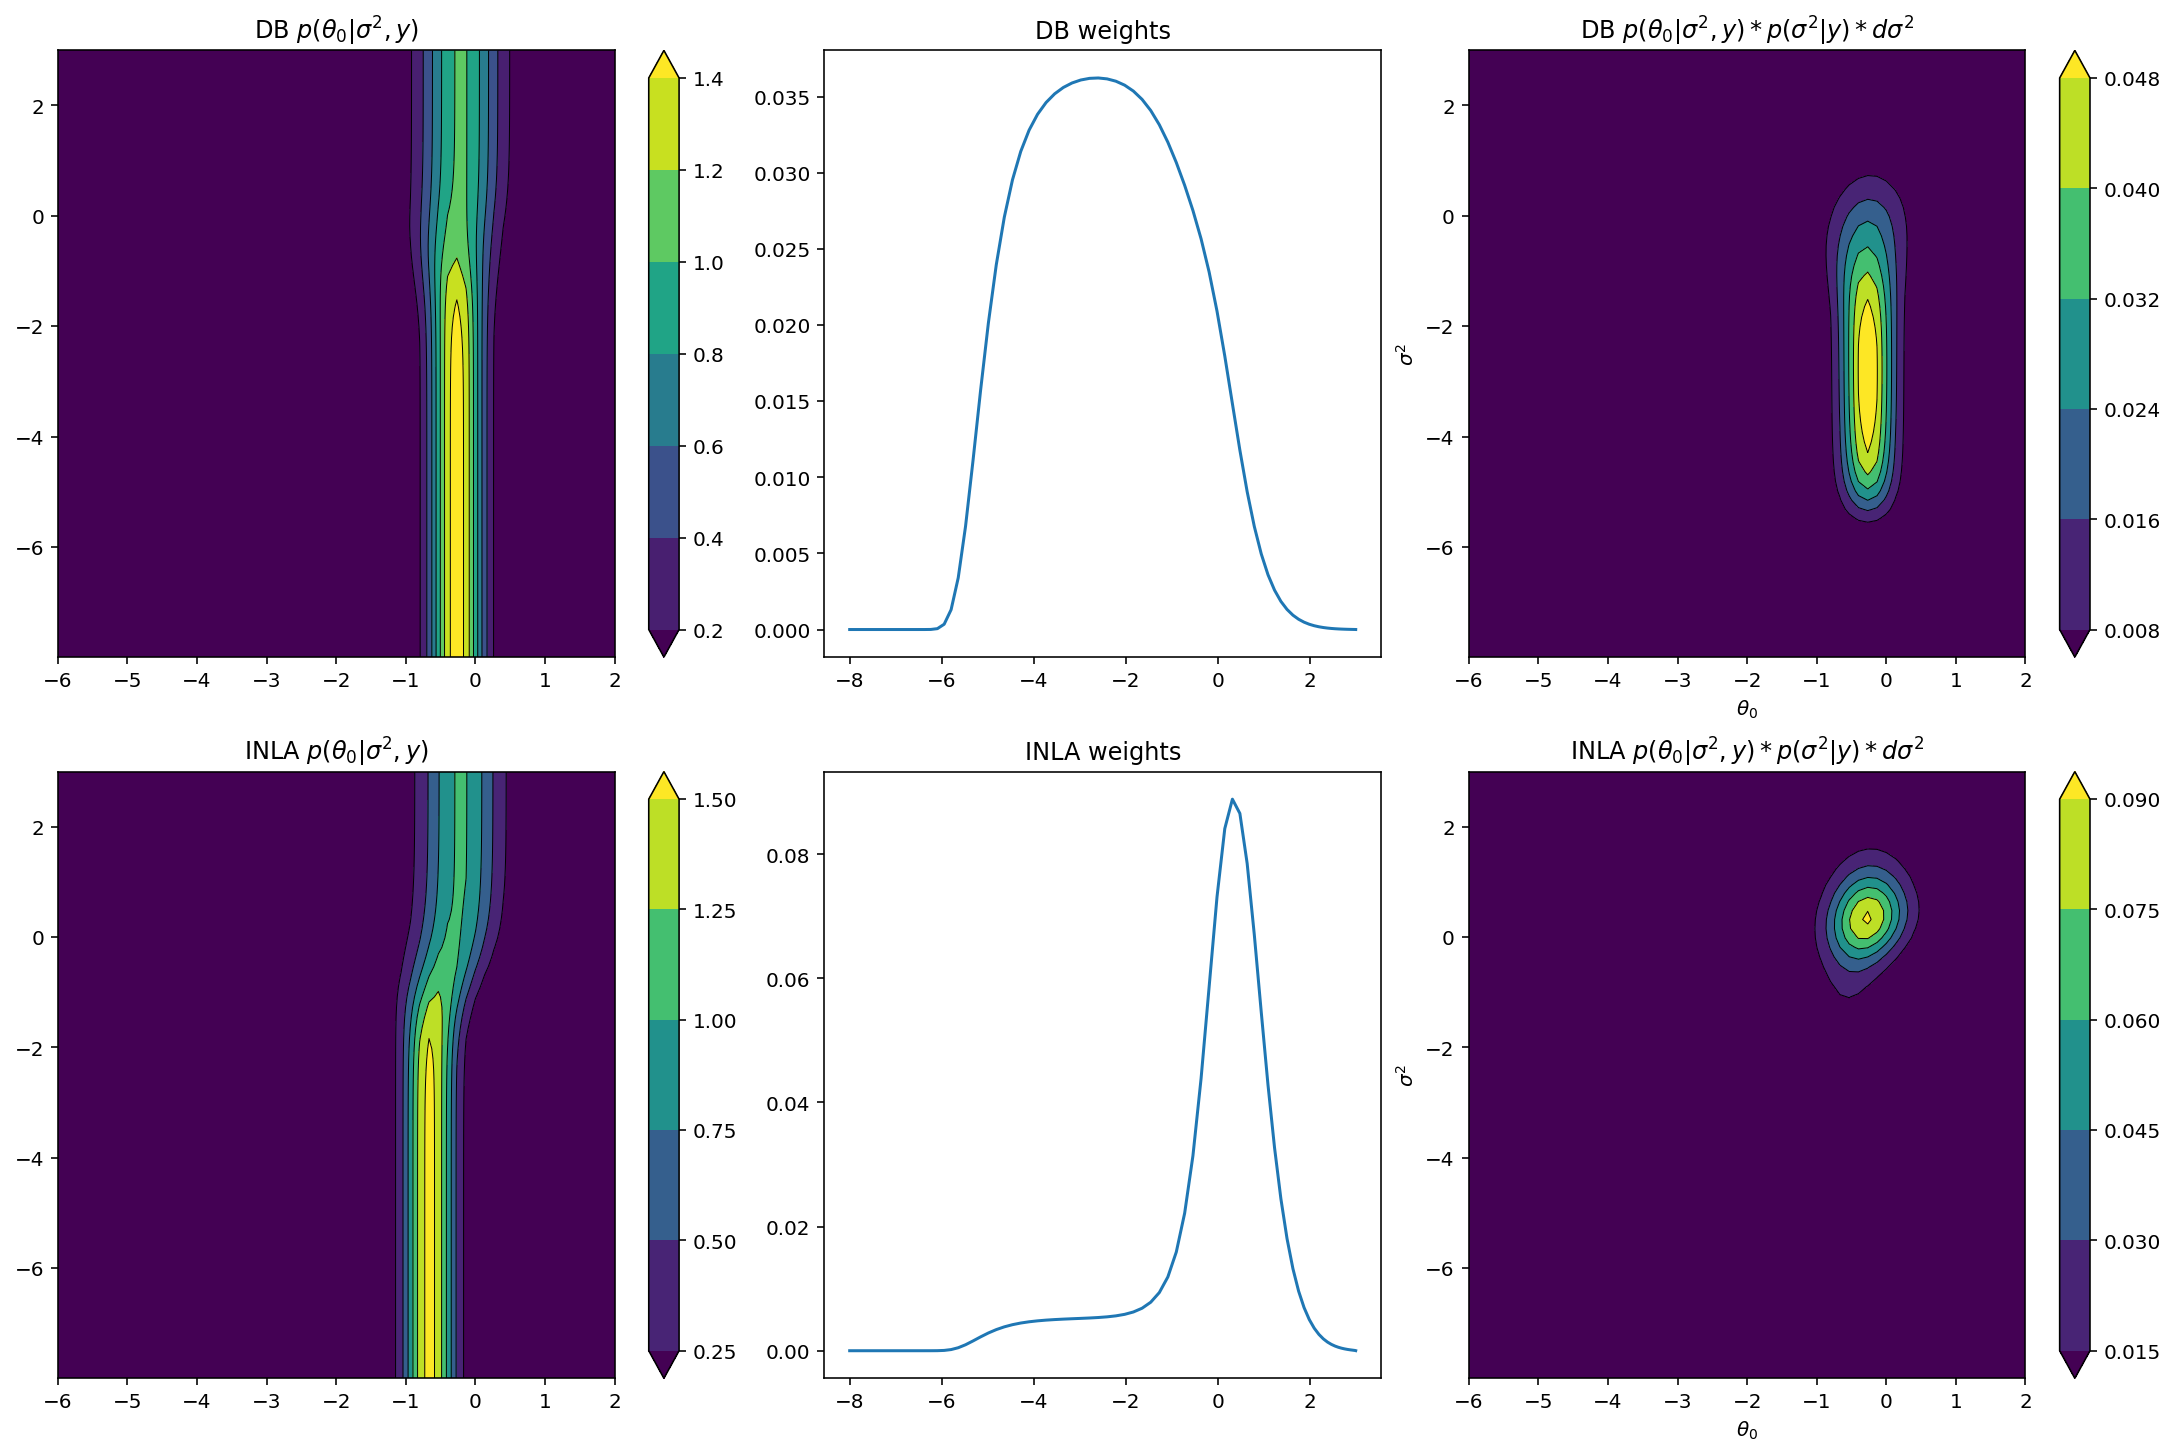

In [ ]:
look_idx = 5
arm_idx = 2
plt.figure(figsize=(15, 10), constrained_layout=True)

# DB
ti_rule = util.simpson_rule(61, -6.0, 2.0)
x_mu = db_stats["mu_posterior"]
x_sigma = np.sqrt(db_stats["sigma2_posterior"])
db_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    x_mu[None, look_idx, :, arm_idx],
    x_sigma[None, 5, :, arm_idx],
)

TT, log_sigma_grid = np.meshgrid(
    ti_rule.pts, np.log10(b.sigma2_rule.pts), indexing="ij"
)
field = db_pdf
levels = None

plt.subplot(2, 3, 1)
plt.title(r"DB $p(\theta_0|\sigma^2,y)$")
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)

plt.subplot(2, 3, 2)
plt.title("DB weights")
plt.plot(
    np.log10(b.sigma2_rule.pts),
    db_stats["sigma2_given_y"][look_idx] * b.sigma2_rule.wts,
)

plt.subplot(2, 3, 3)
plt.title(r"DB $p(\theta_0|\sigma^2,y) * p(\sigma^2|y) * d\sigma^2$")
field = (
    db_pdf * db_stats["sigma2_given_y"][None, look_idx, :] * b.sigma2_rule.wts[None, :]
)
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\sigma^2$")

# INLA
ti_rule = util.simpson_rule(61, -6.0, 2.0)
n_arms = 4
x_mu = report["x0"].reshape((*post_hyper.shape, n_arms))
x_sigma2 = (
    report["model"].sigma2_from_H(report["H"]).reshape((*post_hyper.shape, n_arms))
)
x_sigma = np.sqrt(x_sigma2)
inla_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    x_mu[None, look_idx, :, arm_idx],
    x_sigma[None, 5, :, arm_idx],
)

field = inla_pdf
plt.subplot(2, 3, 4)
plt.title(r"INLA $p(\theta_0|\sigma^2,y)$")
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)

plt.subplot(2, 3, 5)
plt.title("INLA weights")
plt.plot(np.log10(b.sigma2_rule.pts), post_hyper[look_idx] * b.sigma2_rule.wts)

plt.subplot(2, 3, 6)
plt.title(r"INLA $p(\theta_0|\sigma^2,y) * p(\sigma^2|y) * d\sigma^2$")
field = inla_pdf * post_hyper[None, look_idx, :] * b.sigma2_rule.wts[None, :]
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\sigma^2$")

plt.show()

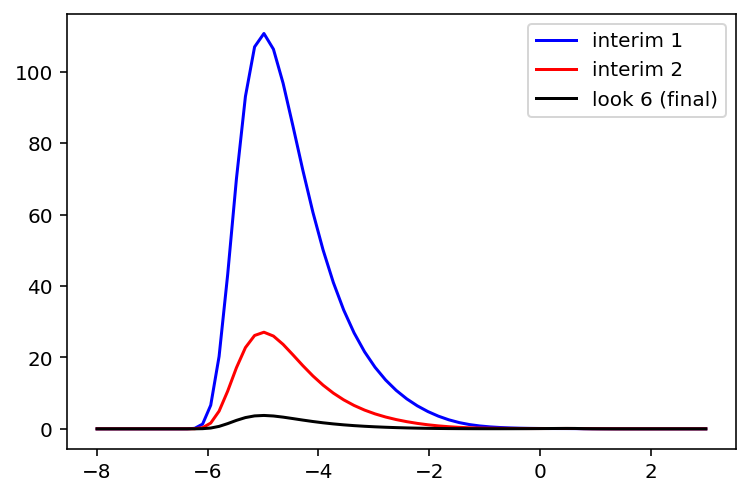

In [ ]:
p_sigma_g_y = quadrature.integrate(b, data[[0, 1, 5]], integrate_thetas=(0, 1, 2, 3))
p_sigma_g_y /= np.sum(p_sigma_g_y * b.sigma2_rule.wts, axis=1)[:, None]
# TODO: would be cool to do a CDF here using a generated product rule for each subset of points.
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[0], "b", label="interim 1")
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[1], "r", label="interim 2")
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[2], "k", label="look 6 (final)")
plt.legend()
plt.show()

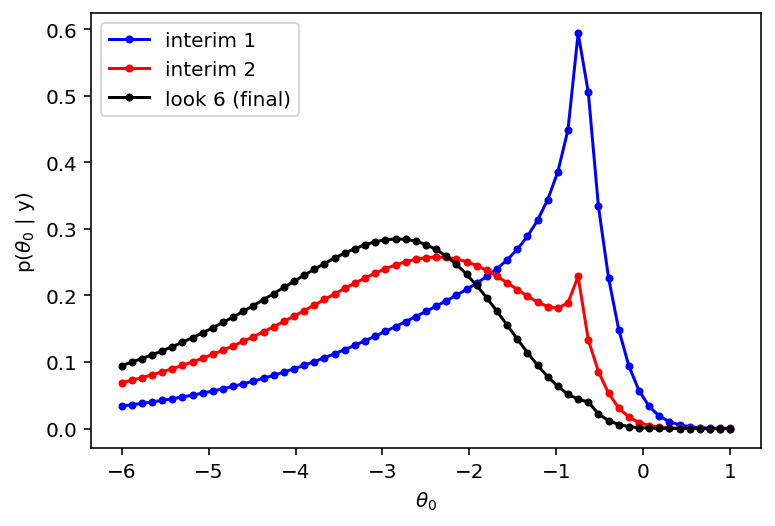

In [ ]:
t0_rule = util.simpson_rule(61, -6.0, 1.0)
p_t0_g_y = quadrature.integrate(
    b,
    data[[0, 1, 5]],
    integrate_sigma2=True,
    integrate_thetas=(1, 2, 3),
    fixed_dims={0: t0_rule},
)
p_t0_g_y /= np.sum(p_t0_g_y * t0_rule.wts, axis=1)[:, None]

plt.plot(t0_rule.pts, p_t0_g_y[0], "b-o", markersize=3, label="interim 1")
plt.plot(t0_rule.pts, p_t0_g_y[1], "r-o", markersize=3, label="interim 2")
plt.plot(t0_rule.pts, p_t0_g_y[2], "k-o", markersize=3, label="look 6 (final)")
plt.legend()
plt.ylabel(r"p($\theta_0$ | y)")
plt.xlabel(r"$\theta_0$")
plt.show()

In [ ]:
theta_map = t0_rule.pts[np.argmax(p_t0_g_y, axis=1)]
theta_map

array([-0.71 , -2.41 , -2.835])

In [ ]:
t0_rule.pts[:3], t0_rule.wts[:3]

(array([-7.   , -6.915, -6.83 ]), array([0.02833333, 0.11333333, 0.05666667]))

In [ ]:
cdf = []
cdf_pts = []
for i in range(3, t0_rule.pts.shape[0], 2):
    # Note that t0_rule.wts[:i] will be different from cdf_rule.wts!!
    cdf_rule = util.simpson_rule(i, t0_rule.pts[0], t0_rule.pts[i - 1])
    cdf.append(np.sum(p_t0_g_y[:, :i] * cdf_rule.wts[:i], axis=1))
    cdf_pts.append(t0_rule.pts[i - 1])
cdf = np.array(cdf)
cdf_pts = np.array(cdf_pts)

In [ ]:
cilow = cdf_pts[np.argmax(cdf > 0.025, axis=0)]
cihi = cdf_pts[np.argmax(cdf > 0.975, axis=0)]
cilow, cihi

(array([-5.98, -6.32, -6.49]), array([-0.2 , -0.54, -0.88]))

In [ ]:
b.suc_thresh

array([[-0.5389965 , -0.5389965 , -0.5389965 , -0.5389965 ],
       [-0.5389965 , -0.5389965 , -0.5389965 , -0.5389965 ],
       [-0.5389965 , -0.5389965 , -0.5389965 , -0.5389965 ],
       [-0.5389965 , -0.5389965 , -0.5389965 , -0.5389965 ],
       [-0.5389965 , -0.5389965 , -0.5389965 , -0.5389965 ],
       [-1.34992672, -1.34992672, -1.34992672, -1.34992672]])

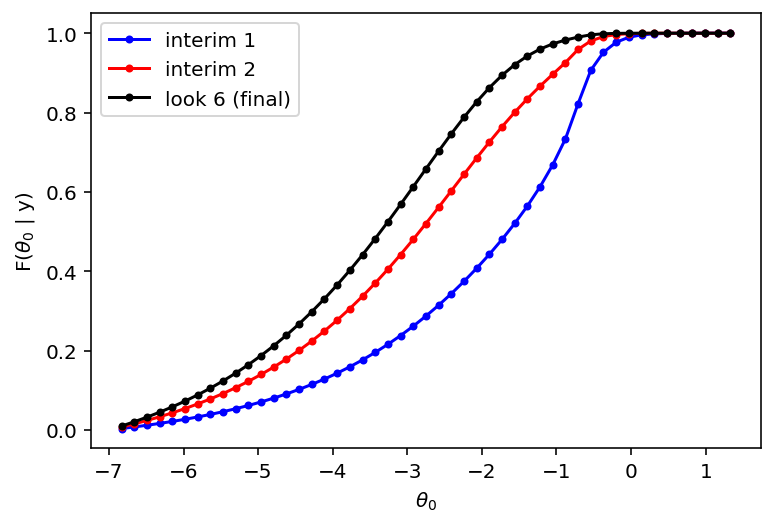

In [ ]:
plt.plot(cdf_pts, cdf[:, 0], "b-o", markersize=3, label="interim 1")
plt.plot(cdf_pts, cdf[:, 1], "r-o", markersize=3, label="interim 2")
plt.plot(cdf_pts, cdf[:, 2], "k-o", markersize=3, label="look 6 (final)")
plt.legend()
plt.ylabel(r"F($\theta_0$ | y)")
plt.xlabel(r"$\theta_0$")
plt.show()

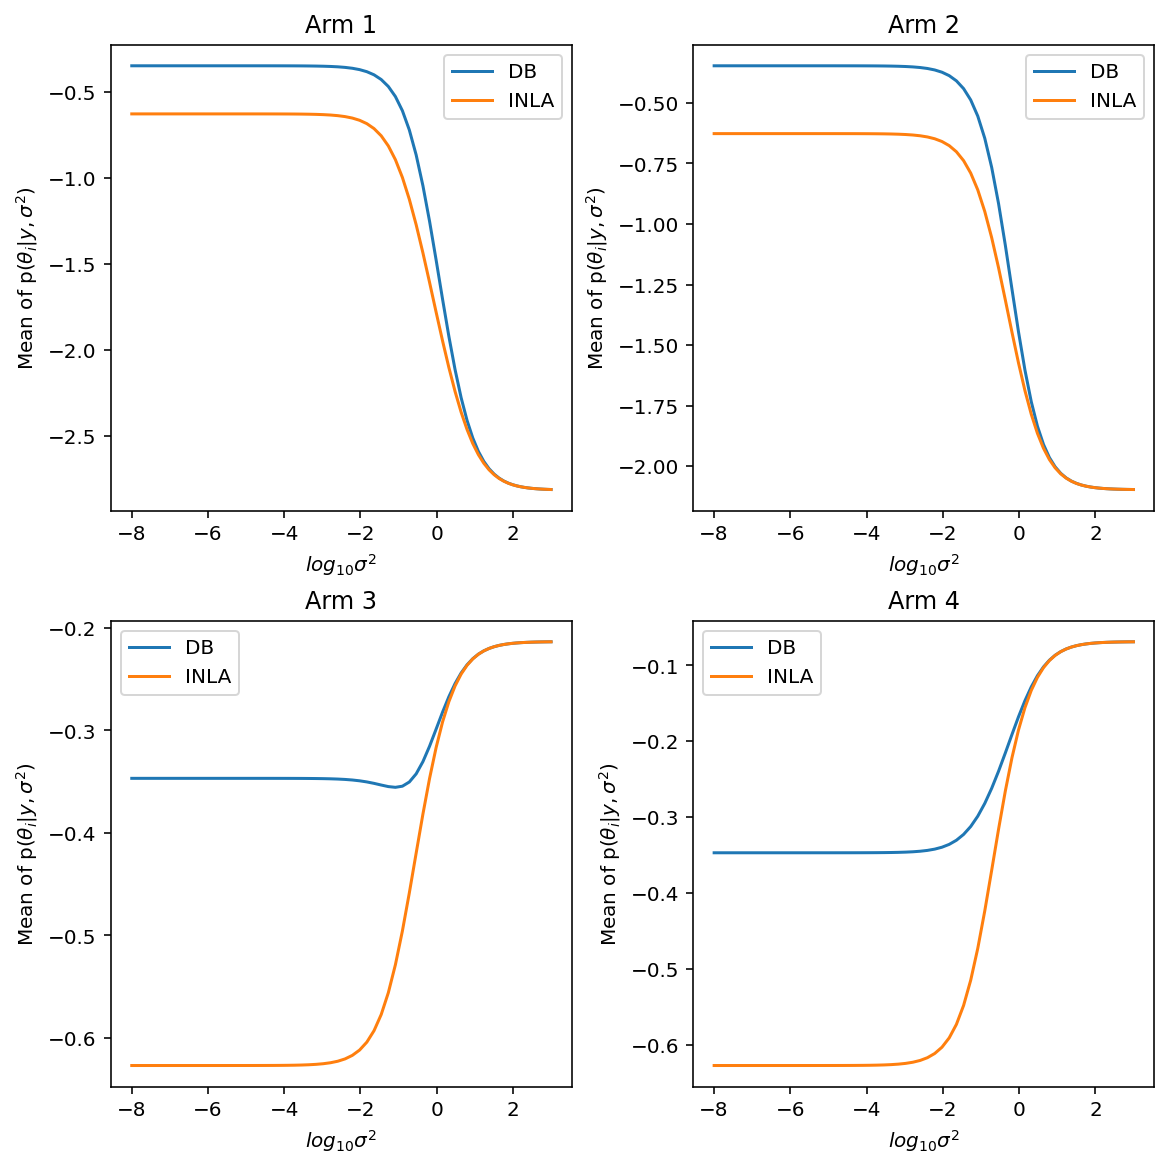

In [ ]:
plt.figure(figsize=(8, 8), constrained_layout=True)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Arm {i+1}")
    inla_graph = report["x0"][5, :, i]
    db_graph = db_stats["mu_posterior"][5, :, i]
    plt.plot(np.log10(b.sigma2_rule.pts), db_graph, label="DB")
    plt.plot(np.log10(b.sigma2_rule.pts), inla_graph, label="INLA")
    plt.ylabel(r"Mean of p($\theta_{i} | y, \sigma^2$)")
    plt.xlabel("$log_{10} \sigma^2$")
    plt.legend()
plt.show()

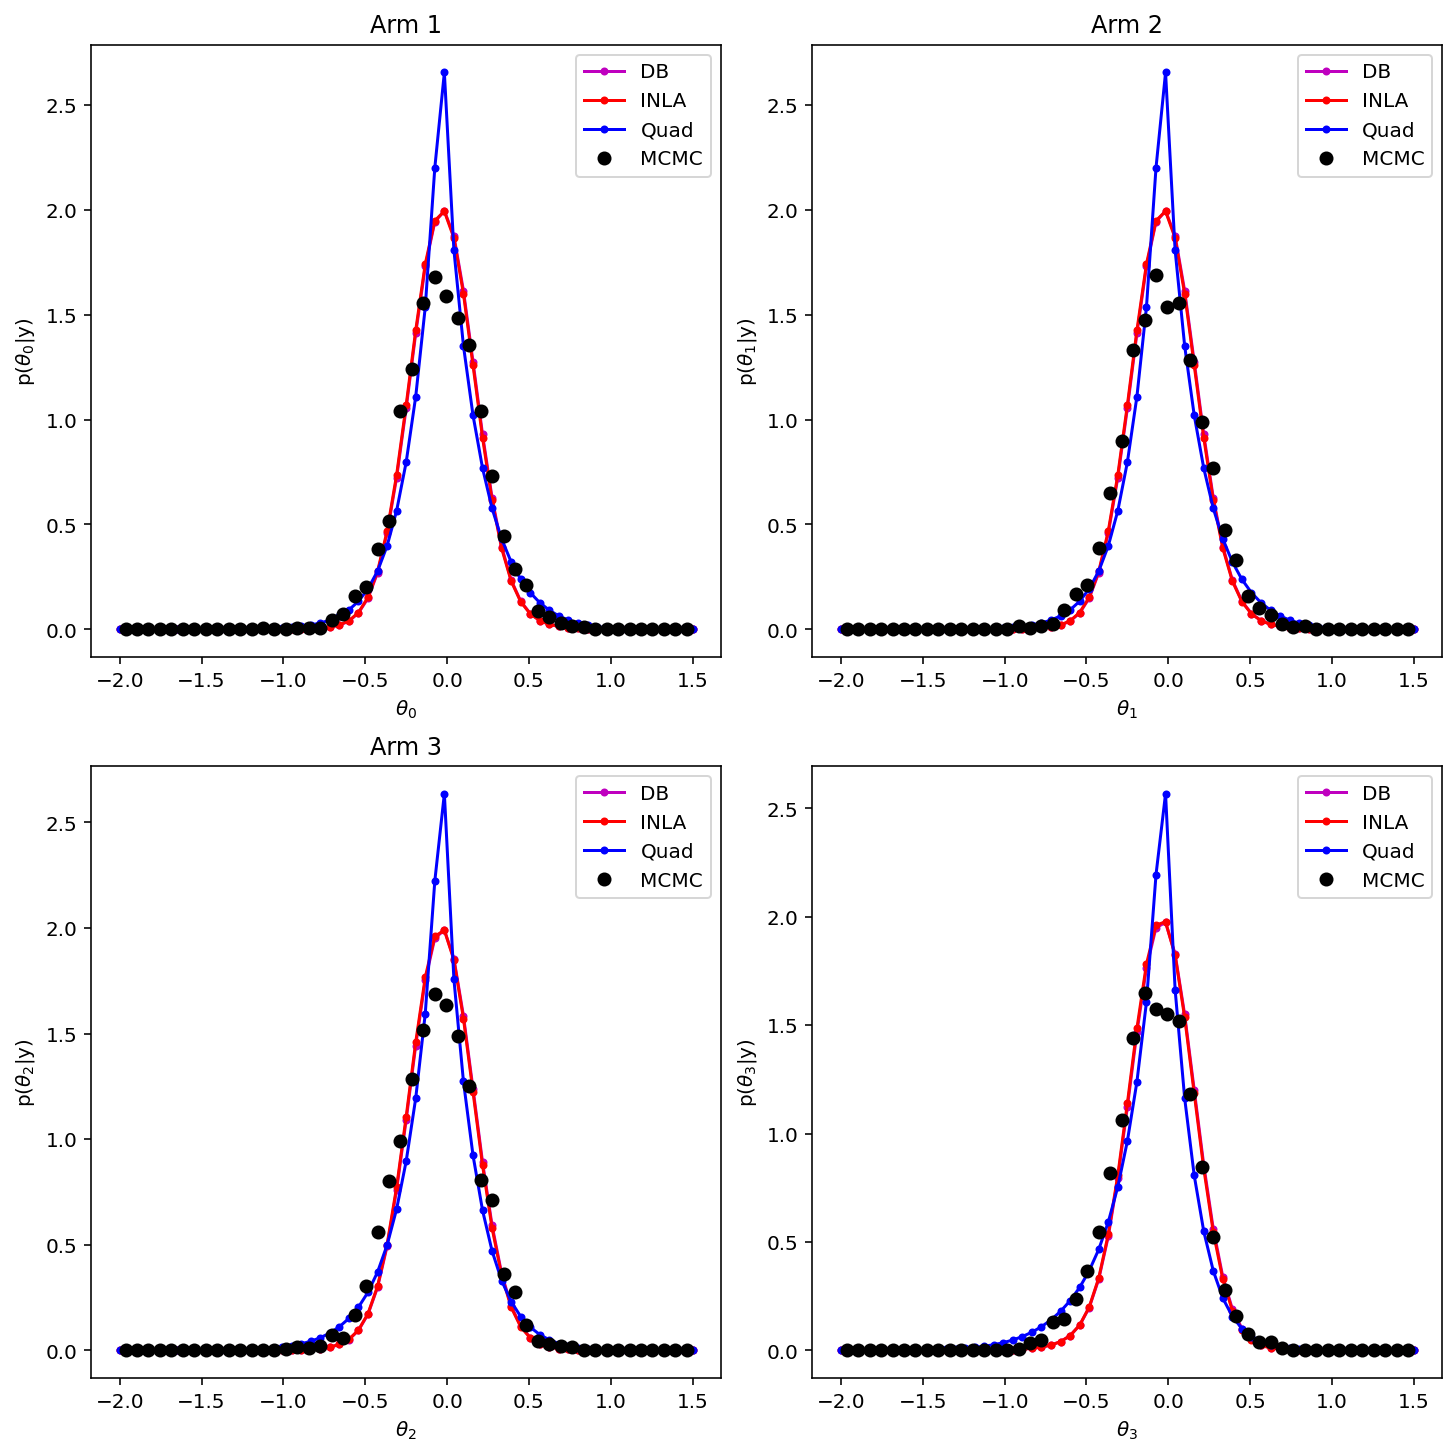

In [ ]:
look_idx = 5
plt.figure(figsize=(10, 10), constrained_layout=True)
for arm_idx in range(4):
    # Quadrature
    ti_rule = util.simpson_rule(61, -2.0, 1.5)
    integrate_dims = [0, 1, 2, 3]
    integrate_dims.remove(arm_idx)
    quad_p_ti_g_y = quadrature.integrate(
        b,
        data[None, look_idx],
        integrate_sigma2=True,
        integrate_thetas=integrate_dims,
        fixed_dims={arm_idx: ti_rule},
        n_theta=9,
    )
    quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts, axis=1)[:, None]

    # MCMC
    mcmc_thetai = np.asarray(
        mcmc_data[look_idx].get_samples(False)["theta"][:, arm_idx]
    )
    domain = (np.min(ti_rule.pts), np.max(ti_rule.pts))
    counts, bin_edges = np.histogram(mcmc_thetai, bins=np.linspace(*domain, 51))
    counts = counts.astype(np.float64)
    counts /= np.sum(counts)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    mcmc_pdf = (counts / np.sum(counts)) / bin_widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # INLA
    n_arms = 4
    x_mu = report["x0"].reshape((*post_hyper.shape, n_arms))
    x_sigma2 = (
        report["model"].sigma2_from_H(report["H"]).reshape((*post_hyper.shape, n_arms))
    )
    x_sigma = np.sqrt(x_sigma2)
    inla_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        x_mu[None, look_idx, :, arm_idx],
        x_sigma[None, 5, :, arm_idx],
    )
    inla_p_ti_g_y = np.sum(
        inla_pdf * post_hyper[None, look_idx, :] * b.sigma2_rule.wts[None, :], axis=1
    )

    # DB
    x_mu = db_stats["mu_posterior"]
    x_sigma = np.sqrt(db_stats["sigma2_posterior"])
    db_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        x_mu[None, look_idx, :, arm_idx],
        x_sigma[None, 5, :, arm_idx],
    )
    db_p_ti_g_y = np.sum(
        db_pdf
        * db_stats["sigma2_given_y"][None, look_idx, :]
        * b.sigma2_rule.wts[None, :],
        axis=1,
    )

    plt.title(f"Arm {arm_idx}")
    plt.subplot(2, 2, arm_idx + 1)
    plt.plot(ti_rule.pts, db_p_ti_g_y, "m-o", markersize=3, label="DB")
    plt.plot(ti_rule.pts, inla_p_ti_g_y, "r-o", markersize=3, label="INLA")
    plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
    plt.plot(bin_centers, mcmc_pdf, "ko", label="MCMC")
    plt.xlabel(f"$\\theta_{arm_idx}$")
    plt.ylabel(f"p($\\theta_{arm_idx}$|y)")
    plt.legend()
plt.show()

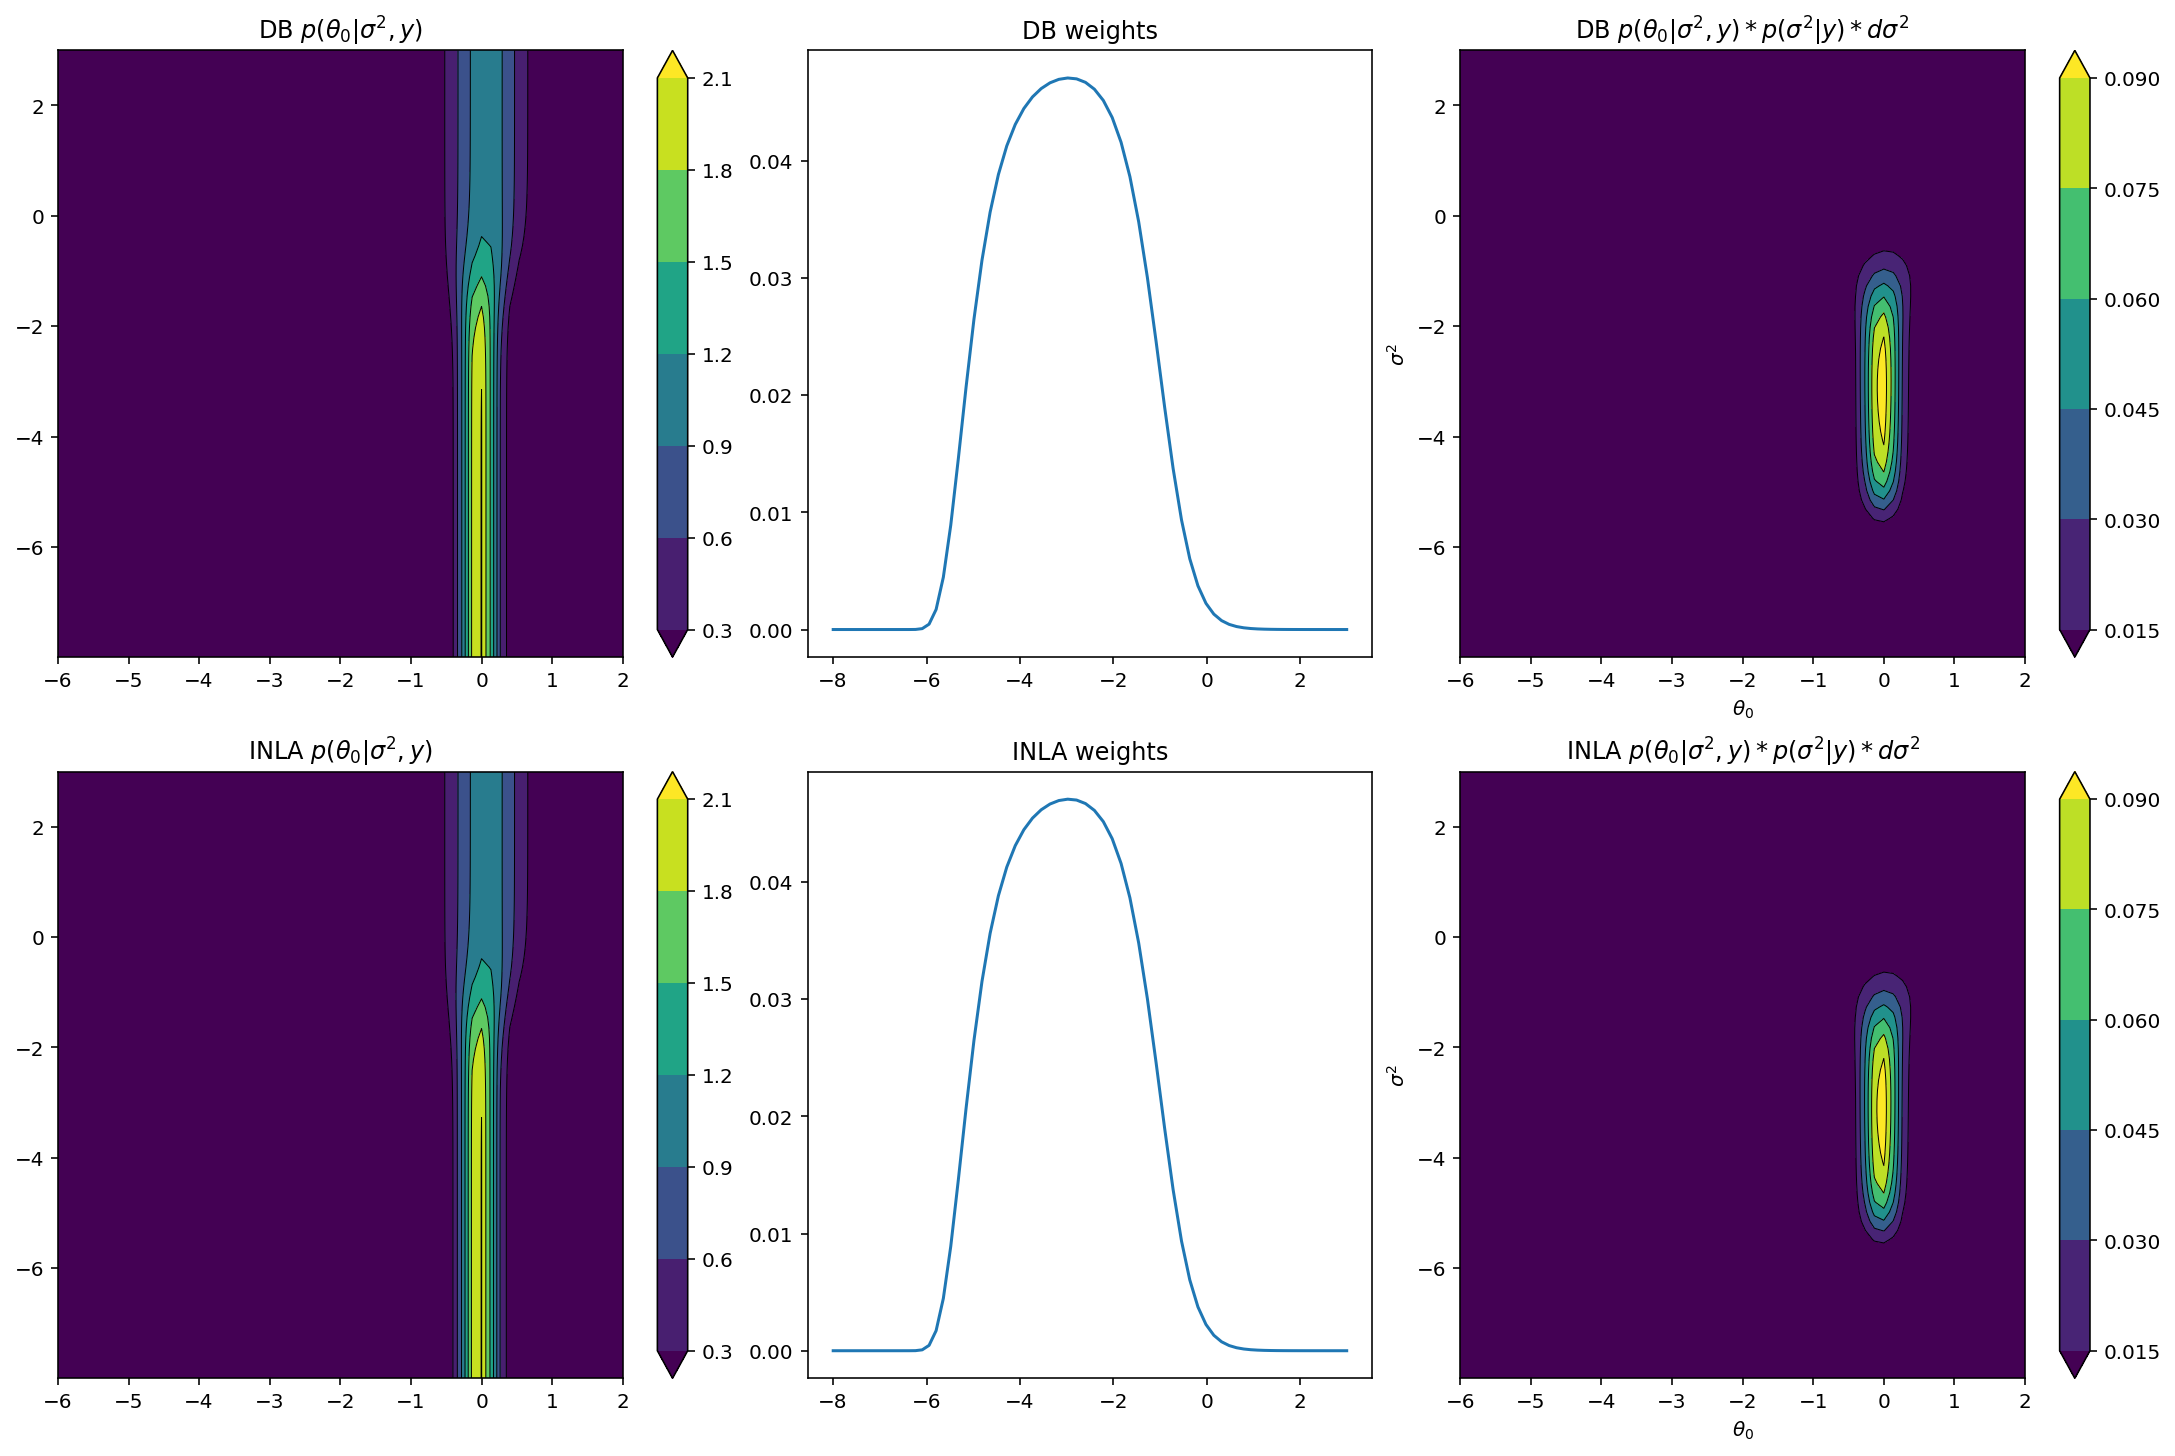

In [ ]:
look_idx = 5
arm_idx = 0
plt.figure(figsize=(15, 10), constrained_layout=True)

# DB
ti_rule = util.simpson_rule(61, -6.0, 2.0)
x_mu = db_stats["mu_posterior"]
x_sigma = np.sqrt(db_stats["sigma2_posterior"])
db_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    x_mu[None, look_idx, :, arm_idx],
    x_sigma[None, 5, :, arm_idx],
)

TT, log_sigma_grid = np.meshgrid(
    ti_rule.pts, np.log10(b.sigma2_rule.pts), indexing="ij"
)
field = db_pdf
levels = None

plt.subplot(2, 3, 1)
plt.title(r"DB $p(\theta_0|\sigma^2,y)$")
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)

plt.subplot(2, 3, 2)
plt.title("DB weights")
plt.plot(
    np.log10(b.sigma2_rule.pts),
    db_stats["sigma2_given_y"][look_idx] * b.sigma2_rule.wts,
)

plt.subplot(2, 3, 3)
plt.title(r"DB $p(\theta_0|\sigma^2,y) * p(\sigma^2|y) * d\sigma^2$")
field = (
    db_pdf * db_stats["sigma2_given_y"][None, look_idx, :] * b.sigma2_rule.wts[None, :]
)
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\sigma^2$")

# INLA
ti_rule = util.simpson_rule(61, -6.0, 2.0)
n_arms = 4
x_mu = report["x0"].reshape((*post_hyper.shape, n_arms))
x_sigma2 = (
    report["model"].sigma2_from_H(report["H"]).reshape((*post_hyper.shape, n_arms))
)
x_sigma = np.sqrt(x_sigma2)
inla_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    x_mu[None, look_idx, :, arm_idx],
    x_sigma[None, 5, :, arm_idx],
)

field = inla_pdf
plt.subplot(2, 3, 4)
plt.title(r"INLA $p(\theta_0|\sigma^2,y)$")
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)

plt.subplot(2, 3, 5)
plt.title("INLA weights")
plt.plot(np.log10(b.sigma2_rule.pts), post_hyper[look_idx] * b.sigma2_rule.wts)

plt.subplot(2, 3, 6)
plt.title(r"INLA $p(\theta_0|\sigma^2,y) * p(\sigma^2|y) * d\sigma^2$")
field = inla_pdf * post_hyper[None, look_idx, :] * b.sigma2_rule.wts[None, :]
cntf = plt.contourf(TT, log_sigma_grid, field, levels=levels, extend="both")
plt.contour(
    TT,
    log_sigma_grid,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\sigma^2$")

plt.show()

### Skewness in the marginals

Why is the confidence interval on the 0-th arm in the figure above so large? This is a case where one of the core INLA assumptions breaks down. INLA assumes that p(x|y,\theta) is approximately normal. In this particular case, that assumption is not correct. Intuitively, with 0 successes out of 20 patients, there is a lot more potential for small $x_0$ values than potential for large $x_0$ values. As you can see below, there is substantial skewness. There are approaches to deal with this. See here: https://github.com/Confirm-Solutions/kevlar/issues/15

In [ ]:
x0_vs = np.linspace(-15, 5, 100)
x123_vs = np.full_like(x0_vs, -1.0)
x = np.array([x0_vs, x123_vs, x123_vs, x123_vs]).T.copy()
lj = model.log_joint(model, x, data[0], np.array([[-1.0, 10.0]]))
plt.plot(x0_vs, np.exp(lj))
plt.show()

In [ ]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta2, report2)

# expit(mu_post) is the posterior estimate of the mean probability.
p_post = scipy.special.expit(mu_post)

# two sigma confidence intervals transformed from logit to probability space.
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

In [ ]:
cilow[0], cihigh[0]

In [ ]:
total_sum = np.sum(np.exp(lj))
mean = x0_vs[np.argmax(np.exp(lj))]
ci025 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.05)]
ci975 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.95)]
ci025, ci975, np.abs(mean - ci025), np.abs(mean - ci975), scipy.special.expit(
    ci025
), scipy.special.expit(ci975)